In [1]:
# !pip install torch
# !pip install transformers datasets
# !pip install scikit-learn
# !pip install seaborn
# !pip install text2num

In [36]:
%load_ext autoreload
%autoreload 2

import os, urllib.request, sys, json, random, math, itertools, re, string, inspect
from tqdm import tqdm
from typing import List, Optional, Union, Tuple
from enum import Enum, auto

import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import Dataset, DataLoader

import transformers
from transformers import AutoTokenizer, AutoModel, EncoderDecoderModel, DataCollatorWithPadding

import datasets

from generate_annotation import annotate_dataset, create_readable_dataset, to_readable_story, AnswerType
from utils import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Preliminaries

In [3]:
class Config():

    class Dataset():
        train_url: str = "https://nlp.stanford.edu/data/coqa/coqa-train-v1.0.json"
        test_url: str = "https://nlp.stanford.edu/data/coqa/coqa-dev-v1.0.json"

        data_dir: str = "data"

        raw_dir: str = os.path.join(data_dir, "raw")
        train_data_raw: str = os.path.join(raw_dir, "train.json")
        test_data_raw: str = os.path.join(raw_dir, "test.json")

        annotated_dir: str = os.path.join(data_dir, "annotated")
        train_data_annotated: str = os.path.join(annotated_dir, "train.json")
        test_data_annotated: str = os.path.join(annotated_dir, "test.json")

        readable_dir: str = os.path.join(data_dir, "readable")
        train_data_readable: str = os.path.join(readable_dir, "train.txt")
        test_data_readable: str = os.path.join(readable_dir, "test.txt")

        processed_dir: str = os.path.join(data_dir, "processed")
        final_dir: str = os.path.join(data_dir, "final")
        final_no_history: str = os.path.join(final_dir, "final_no_history")
        final_with_history: str = os.path.join(final_dir, "final_with_history")

    class Checkpoints():
        def __init__(self,
                     distil_roberta="distilroberta-base",
                     bert_tiny="prajjwal1/bert-tiny") -> None:
            self.distil_roberta = distil_roberta
            self.bert_tiny = bert_tiny

    dataset: Dataset = Dataset()
    checkpoints: Checkpoints = Checkpoints()


CONFIG: Config = Config()

In [4]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.use_deterministic_algorithms(True)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False


# Using a generator and the following function as `worker_init_fn` preserves reproducibility when using DataLoader
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)


def create_reproducible_dataloader(*args, **kwargs):
    generator = torch.Generator()
    return DataLoader(*args,
                      **kwargs,
                      worker_init_fn=seed_worker,
                      generator=generator)

# [Task 1] Remove unaswerable QA pairs

## Download the dataset

In [5]:
class DownloadProgressBar(tqdm):

    def update_to(self, b=1, bsize=1, tsize=None):
        if tsize is not None:
            self.total = tsize
        self.update(b * bsize - self.n)


def download_url(url, output_path):
    with DownloadProgressBar(unit='B',
                             unit_scale=True,
                             miniters=1,
                             desc=url.split('/')[-1]) as t:
        urllib.request.urlretrieve(url,
                                   filename=output_path,
                                   reporthook=t.update_to)


def download_data(url_path, output_path, split):
    create_dirs_for_file(output_path)

    if not os.path.exists(output_path):
        print(f"Downloading CoQA {split} data split... (it may take a while)")
        download_url(url=url_path, output_path=output_path)
        print("Download completed!")

In [6]:
download_data(CONFIG.dataset.train_url, CONFIG.dataset.train_data_raw, "train")
download_data(CONFIG.dataset.test_url, CONFIG.dataset.test_data_raw, "test")

## Remove unanswerable QA pairs

We perform an automated annotation process, where we assign each answer a specific answer type:
- `unknown`: unanswerable question - we check if (`span_start`, `span_end`) = (-1, -1)
- `span`: answer overlaps with the passage, after ignoring punctuation and case mismatches
- `yes_no`: answer is Yes or No
- `counting`: answer is the result of a counting process - we check if the answer is a written number or a digit
- `multiple_choice`: answer is one the choices provided in the question - we check if the question has an `or` and contains the answer
- `fluency`: changes to the text span to improve fluency - if the answer is none of the previous, we flag it as `fluency`

Although the automated annotation procedure is susceptible to errors, with some `span` answers being annotated as `counting`, we believe that it is reliable and provides a useful starting point for analyzing the dataset.

In [7]:
def generate_annotated_dataset(raw_filename,
                               annotated_filename,
                               ignore_additional_answers=True):
    if not os.path.exists(annotated_filename):
        print("Generating annotated data...", end="")
        annotate_dataset(raw_filename,
                         annotated_filename,
                         ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_annotated_dataset(CONFIG.dataset.train_data_raw,
                           CONFIG.dataset.train_data_annotated)

generate_annotated_dataset(CONFIG.dataset.test_data_raw,
                           CONFIG.dataset.test_data_annotated)

In [8]:
dataset = datasets.load_dataset("json", data_files=CONFIG.dataset.train_data_annotated, field="data")
test_dataset = datasets.load_dataset("json", data_files=CONFIG.dataset.test_data_annotated, field="data", split="train")
dataset["test"] = test_dataset.remove_columns(list(set(test_dataset.features).difference(dataset["train"].features)))

print(dataset)

Found cached dataset json (C:/Users/Simone999/.cache/huggingface/datasets/json/default-07ae0c4c5137cda0/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


  0%|          | 0/1 [00:00<?, ?it/s]

Found cached dataset json (C:/Users/Simone999/.cache/huggingface/datasets/json/default-9dc71b0f0ec420a9/0.0.0/0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51)


DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name'],
        num_rows: 500
    })
})


Let's remove unknown qa pairs.

In [9]:
def remove_unknown_qa(example):
    questions = []
    answers = []
    last_turn = 0
    for question_item, answer_item in zip(example["questions"],
                                          example["answers"]):
        last_turn += 1
        if question_item["answer_type"] != "unknown":
            questions.append(question_item)
            answers.append(answer_item)

    qa_length = len(questions)
    return {
        # 'id': example['id'],
        # 'source': example['source'],
        # 'filename': example['filename'],
        # 'passage': example['story'],
        'questions': questions,
        'answers': answers,
        'qa_length': qa_length,
        'last_turn': last_turn,
    }

print("Removing unknown qa pairs...")
processed_dataset = dataset.map(remove_unknown_qa)
print("Done!")

print(processed_dataset)

Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-07ae0c4c5137cda0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-bbcb05921054655a.arrow
Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-9dc71b0f0ec420a9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-3ae48f74c1a14be1.arrow


Removing unknown qa pairs...
Done!
DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 7199
    })
    test: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


We have to check whether there are examples with no qa pairs and remove them from the dataset.

In [10]:
examples_with_no_qa = processed_dataset.filter(lambda example: example["qa_length"] == 0)
print("Examples with no qa pairs:", examples_with_no_qa.num_rows)

examples_with_no_qa = examples_with_no_qa["train"]
examples_with_no_qa.set_format("pandas")
display(examples_with_no_qa[:])

print()
print("Filtering out examples with no qa pairs...")
processed_dataset = processed_dataset.filter(lambda example: example["qa_length"] > 0)
print("Done!")

print()
print("Number of examples:", processed_dataset.num_rows)

Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-07ae0c4c5137cda0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-ca38db5629640f00.arrow
Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-9dc71b0f0ec420a9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-76b74a56cba90b1b.arrow


Examples with no qa pairs: {'train': 6, 'test': 0}


,source,id,filename,story,questions,answers,name,qa_length,last_turn
0,cnn,3igi0vl647kltzms1bysq3xdroknoh,cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...,The rare moments Christos Sourovelis can take ...,[],[],cnn_19c86874df2b653f86acfe4e8cc3d9f795abff1f.s...,0,1
1,cnn,3p4rdnwnd56fenk4oitvdzka5nuija,cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...,A senior Palestinian Authority official died W...,[],[],cnn_73de0878323d26e0d07d8a193e835375e89eaa54.s...,0,1
2,wikipedia,35gmh2sv3ehhzt9f8cv90g34dznoe3,Index_Medicus.txt,Index Medicus (IM) is a curated subset of MEDL...,[],[],Index_Medicus.txt,0,1
3,cnn,39rp059mehtvsncjl5e6748efztmbe,cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...,"Seoul, South Korea (CNN) -- Korean is consider...",[],[],cnn_c02782c5a5a0ccd8f4454ae80be51731913ecfbc.s...,0,1
4,mctest,3sbehtycwn359cf3aiuynmzyiykiyz,mc500.train.252,John was an old man who lived in New York City...,[],[],mc500.train.252,0,1
5,race,3zdad0o1t1d6il54zy70ifuyshmxtm,middle7342.txt,"Danny lived for football. He played it, watche...",[],[],middle7342.txt,0,1


Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-07ae0c4c5137cda0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-36ce32d0d019aff1.arrow
Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-9dc71b0f0ec420a9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-f53bf43144806d30.arrow



Filtering out examples with no qa pairs...
Done!

Number of examples: {'train': 7193, 'test': 500}


In [11]:
processed_dataset.save_to_disk(CONFIG.dataset.processed_dir)
del processed_dataset
del dataset

Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-07ae0c4c5137cda0\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-97182bb6adc9f979.arrow


Saving the dataset (0/1 shards):   0%|          | 0/7193 [00:00<?, ? examples/s]

Loading cached processed dataset at C:\Users\Simone999\.cache\huggingface\datasets\json\default-9dc71b0f0ec420a9\0.0.0\0f7e3662623656454fcd2b650f34e886a7db4b9104504885bd462096cc7a9f51\cache-11a112379d94e470.arrow


Saving the dataset (0/1 shards):   0%|          | 0/500 [00:00<?, ? examples/s]

## Data Inspection

In [12]:
dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 7193
    })
    test: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


The dataset is very difficult to explore in a Jupyter notebook. To overcome this, we create a readable `.txt` version, similar to the one provided by the authors of CoQA. For each story, the format is:

```
source: <source>, id: <id>

<passage>

turn: 1
Q   <question_1> || <question_type_1>
A   <answer_1> || <rationale_1> || <answer_type_1>
                        .
                        .
                        .
turn: i
Q   <question_i> || <question_type_i>
A   <answer_i> || <rationale_i> || <answer_type_i>
                        .
                        .
                        .
```

In [13]:
def generate_readable_dataset(annotated_filename,
                              readable_filename,
                              ignore_additional_answers=True):
    if not os.path.exists(readable_filename):
        print("Generating readable data...", end="")
        create_readable_dataset(
            annotated_filename,
            readable_filename,
            ignore_additional_answers=ignore_additional_answers)
        print("Done!")


generate_readable_dataset(CONFIG.dataset.train_data_annotated,
                          CONFIG.dataset.train_data_readable)
generate_readable_dataset(CONFIG.dataset.test_data_annotated,
                          CONFIG.dataset.test_data_readable)

Here, we show an example of story.

In [14]:
sample_id = np.random.choice(dataset["train"].num_rows)
sample = dataset["train"][sample_id]

story_signature = set(inspect.signature(to_readable_story).parameters)
story_kwargs = {
                argument: value for argument, value in sample.items() if argument in story_signature
            }
readable_story = to_readable_story(**story_kwargs)
print(readable_story)

source: wikipedia, id: 37uqdcyh6xvrgy32mg3hpy5vn877vz

The 1936 Summer Olympics (German: "Olympische Sommerspiele 1936"), officially known as the Games of the XI Olympiad, was an international multi-sport event that was held in 1936 in Berlin, Germany. Berlin won the bid to host the Games over Barcelona, Spain, on 26 April 1931, at the 29th IOC Session in Barcelona (two years before the Nazis came to power). It marked the second and final time the International Olympic Committee gathered to vote in a city that was bidding to host those Games. 

To outdo the Los Angeles games of 1932, Adolf Hitler had built a new 100,000-seat track and field stadium, six gymnasiums, and many other smaller arenas. The games were the first to be televised, and radio broadcasts reached 41 countries. Filmmaker Leni Riefenstahl was commissioned by the German Olympic Committee to film the Games for $7 million. Her film, titled "Olympia", pioneered many of the techniques now common in the filming of sports. 



Let's see some statistics.

In [15]:
df = create_dataframe(dataset)
del dataset

print(f"Number of passages: {len(df)}")
print(f"Number of QA pairs: {df['qa_length'].sum()}")
print(f"Number of files: {len(df['filename'].unique())}")

Number of passages: 7693
Number of QA pairs: 115204
Number of files: 7065


In [16]:
print(f"Questions dictionary keys:\t {list(df.loc[0, 'questions'][0].keys())}")
print(f"Answers dictionary keys:\t {list(df.loc[0, 'answers'][0].keys())}")

Questions dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'turn_id']
Answers dictionary keys:	 ['answer_type', 'bad_turn', 'input_text', 'span_end', 'span_start', 'span_text', 'turn_id']


In [17]:
print("Distribution of splits: ")
split_counts = df['split'].value_counts()
print(split_counts)

Distribution of splits: 
train    7193
test      500
Name: split, dtype: int64


In [18]:
print("Conversations with gaps in the history (%)")
broken_hist_counts = df[df["qa_length"] < df["last_turn"]]["split"].value_counts()
print(broken_hist_counts / split_counts * 100)

Conversations with gaps in the history (%)
train    15.584596
test     11.600000
Name: split, dtype: float64


<Axes: title={'center': 'Conversation length'}, xlabel='qa_length', ylabel='split'>

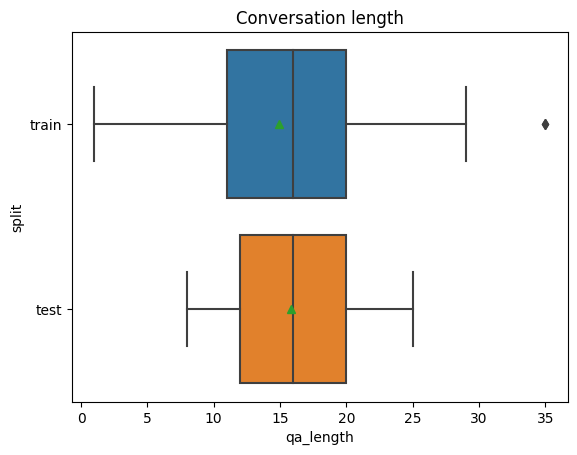

In [19]:
plt.title("Conversation length")
sns.boxplot(data=df, x="qa_length", y="split", showmeans=True)

Here, we want to statistics about number of words/tokens.

In [20]:
tokenizers_ = {k: AutoTokenizer.from_pretrained(checkpoint).tokenize for k, checkpoint in CONFIG.checkpoints.__dict__.items()}
tokenizers = {"": str.split}
tokenizers.update(tokenizers_)

passage_length                                                          
               count      mean        std    min     25%    50%    75%     max
split                                                                         
test           500.0  261.8220  71.018995  124.0  221.75  261.0  292.0   804.0
train         7193.0  271.0228  64.901153   70.0  245.00  266.0  293.0  1030.0

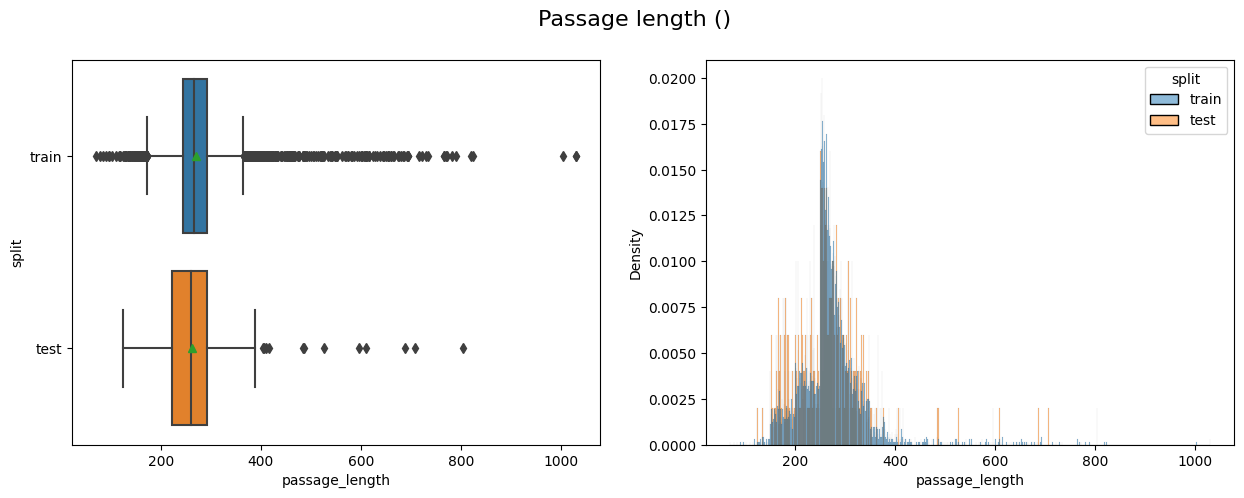

Token indices sequence length is longer than the specified maximum sequence length for this model (711 > 512). Running this sequence through the model will result in indexing errors


distil_roberta


passage_length                                                     \
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  345.926000  99.027458  148.0  283.0  352.5  399.0   
train         7193.0  362.021271  89.147521   89.0  320.0  364.0  401.0   

               
          max  
split          
test   1045.0  
train  1375.0

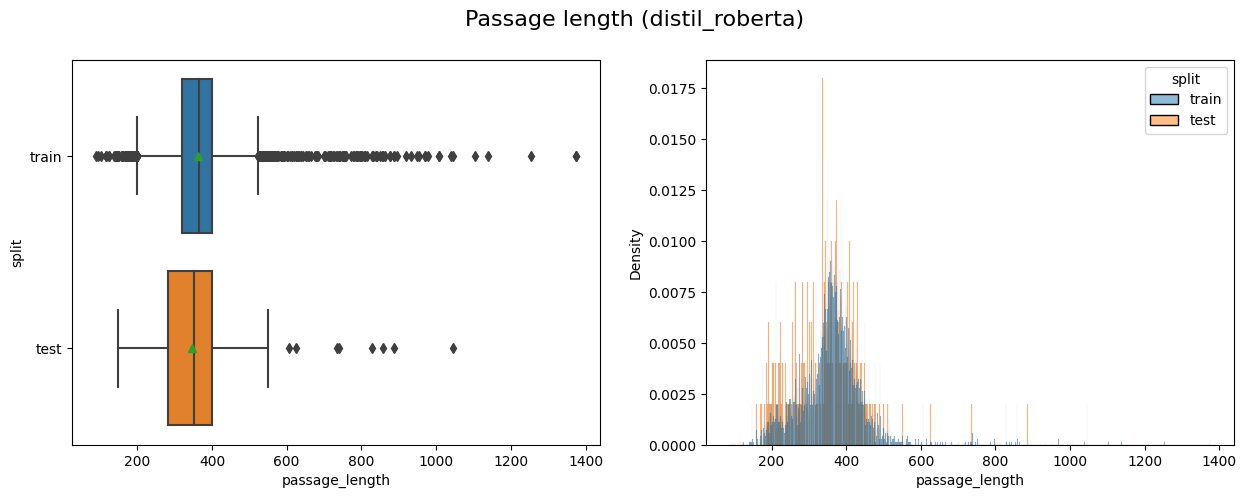

bert_tiny


passage_length                                                     \
               count        mean        std    min    25%    50%    75%   
split                                                                     
test           500.0  336.386000  95.933244  149.0  275.5  342.0  382.0   
train         7193.0  350.610455  85.863011   87.0  310.0  349.0  387.0   

               
          max  
split          
test   1036.0  
train  1322.0

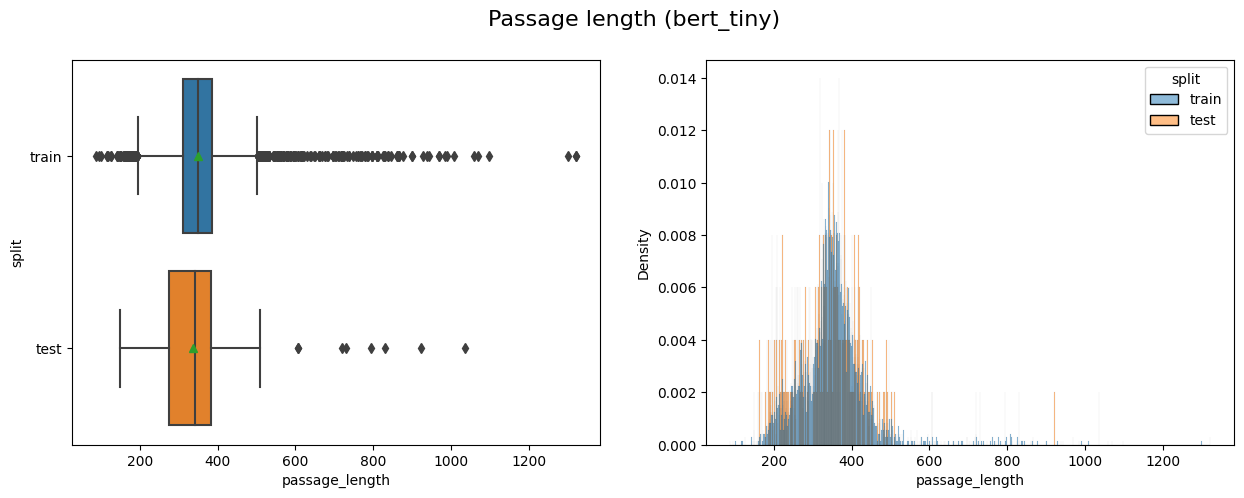

In [21]:
def plot_length(dataset: pd.DataFrame,
                column: str,
                column_name: Optional[str] = None,
                split_fn=str.split,
                notes: Optional[str] = None):
    if column_name is None:
        column_name = column

    length_col = column_name + "_length"
    length = dataset[column].apply(split_fn).apply(len)
    dp = dataset[["split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby("split").describe())

    fig, axes = plt.subplots(1, 2, figsize=(15, 5))
    sns.boxplot(data=dp, x=length_col, y="split", showmeans=True, ax=axes[0])
    sns.histplot(dp,
                 x=length_col,
                 hue="split",
                 stat="density",
                 common_norm=False,
                 discrete=True,
                 ax=axes[1])
    fig.suptitle(f"{column_name.capitalize()} length ({notes})", fontsize=16)
    plt.show()


for name, tokenize_fn in tokenizers.items():
    plot_length(df,
                column="story",
                column_name="passage",
                split_fn=tokenize_fn,
                notes=name)


To analyze questions, answers and rationales, let's explode them.

In [22]:
qa_dataset = explode_qa(df)
assert not np.any(qa_dataset["answer_type"] == "unknown")
del df

question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  5.466279  2.458356  1.0  4.0  5.0  7.0  23.0
train        107286.0  5.457534  2.472842  1.0  4.0  5.0  7.0  42.0

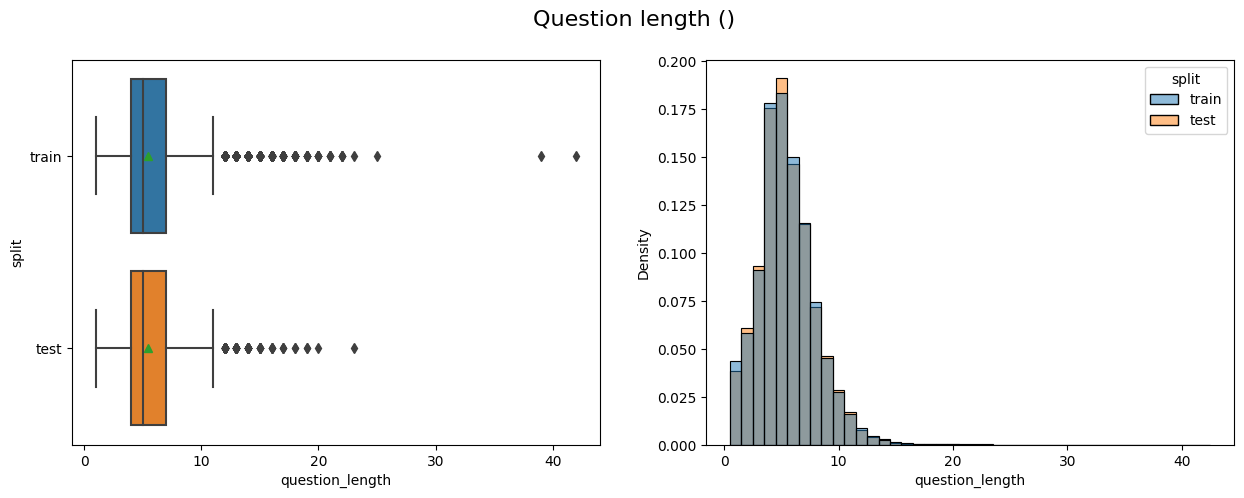

distil_roberta


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.680349  2.663522  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.709962  2.698654  1.0  5.0  6.0  8.0  51.0

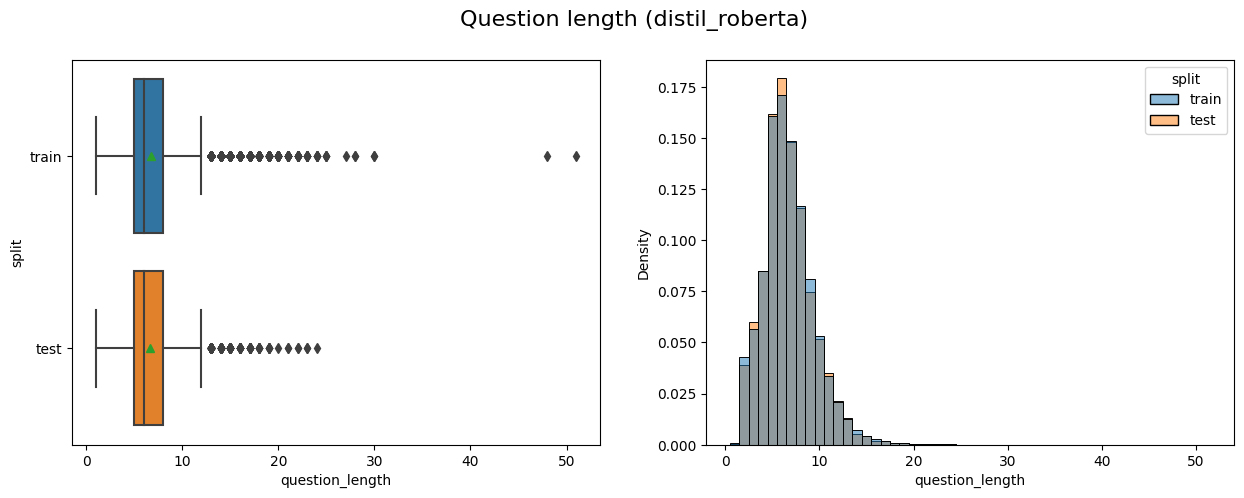

bert_tiny


question_length                                              
                count      mean       std  min  25%  50%  75%   max
split                                                              
test           7918.0  6.689189  2.686615  1.0  5.0  6.0  8.0  24.0
train        107286.0  6.718509  2.720698  1.0  5.0  6.0  8.0  51.0

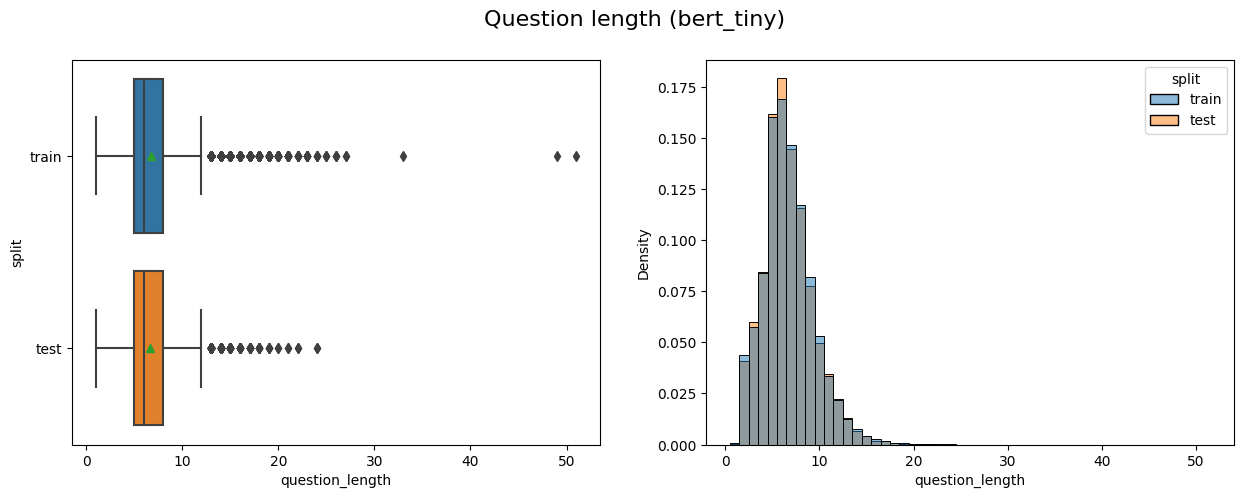

In [23]:
for name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="question",
                split_fn=tokenize_fn,
                notes=name)

According to the SQUAD metric, gold and predicted answers are compared after being normalized, i.e. by lowering text, removing articles, punctuation, and double spaces.

answer_length                                          \
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train         946.0  1.003171  0.056254  1.0  1.0  1.0  1.0   
fluency         test         1003.0  3.953141  2.446799  1.0  2.0  3.0  5.0   
                train       13760.0  4.145494  2.911799  1.0  2.0  3.0  5.0   
multiple_choice test           33.0  1.030303  0.174078  1.0  1.0  1.0  1.0   
                train         262.0  1.125954  0.474820  1.0  1.0  1.0  1.0   
span            test         5192.0  2.424307  2.017944  1.0  1.0  2.0  3.0   
                train       71348.0  2.576330  2.762757  0.0  1.0  2.0  3.0   
yes_no          test         1619.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train       20970.0  1.000000  0.000000  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    2.0  
fluency         test    18.0  
                train   55.0  
multiple_choice test     2.0  
                train    5.0  
span            test    19.0  
                train  320.0  
yes_no          test     1.0  
                train    1.0

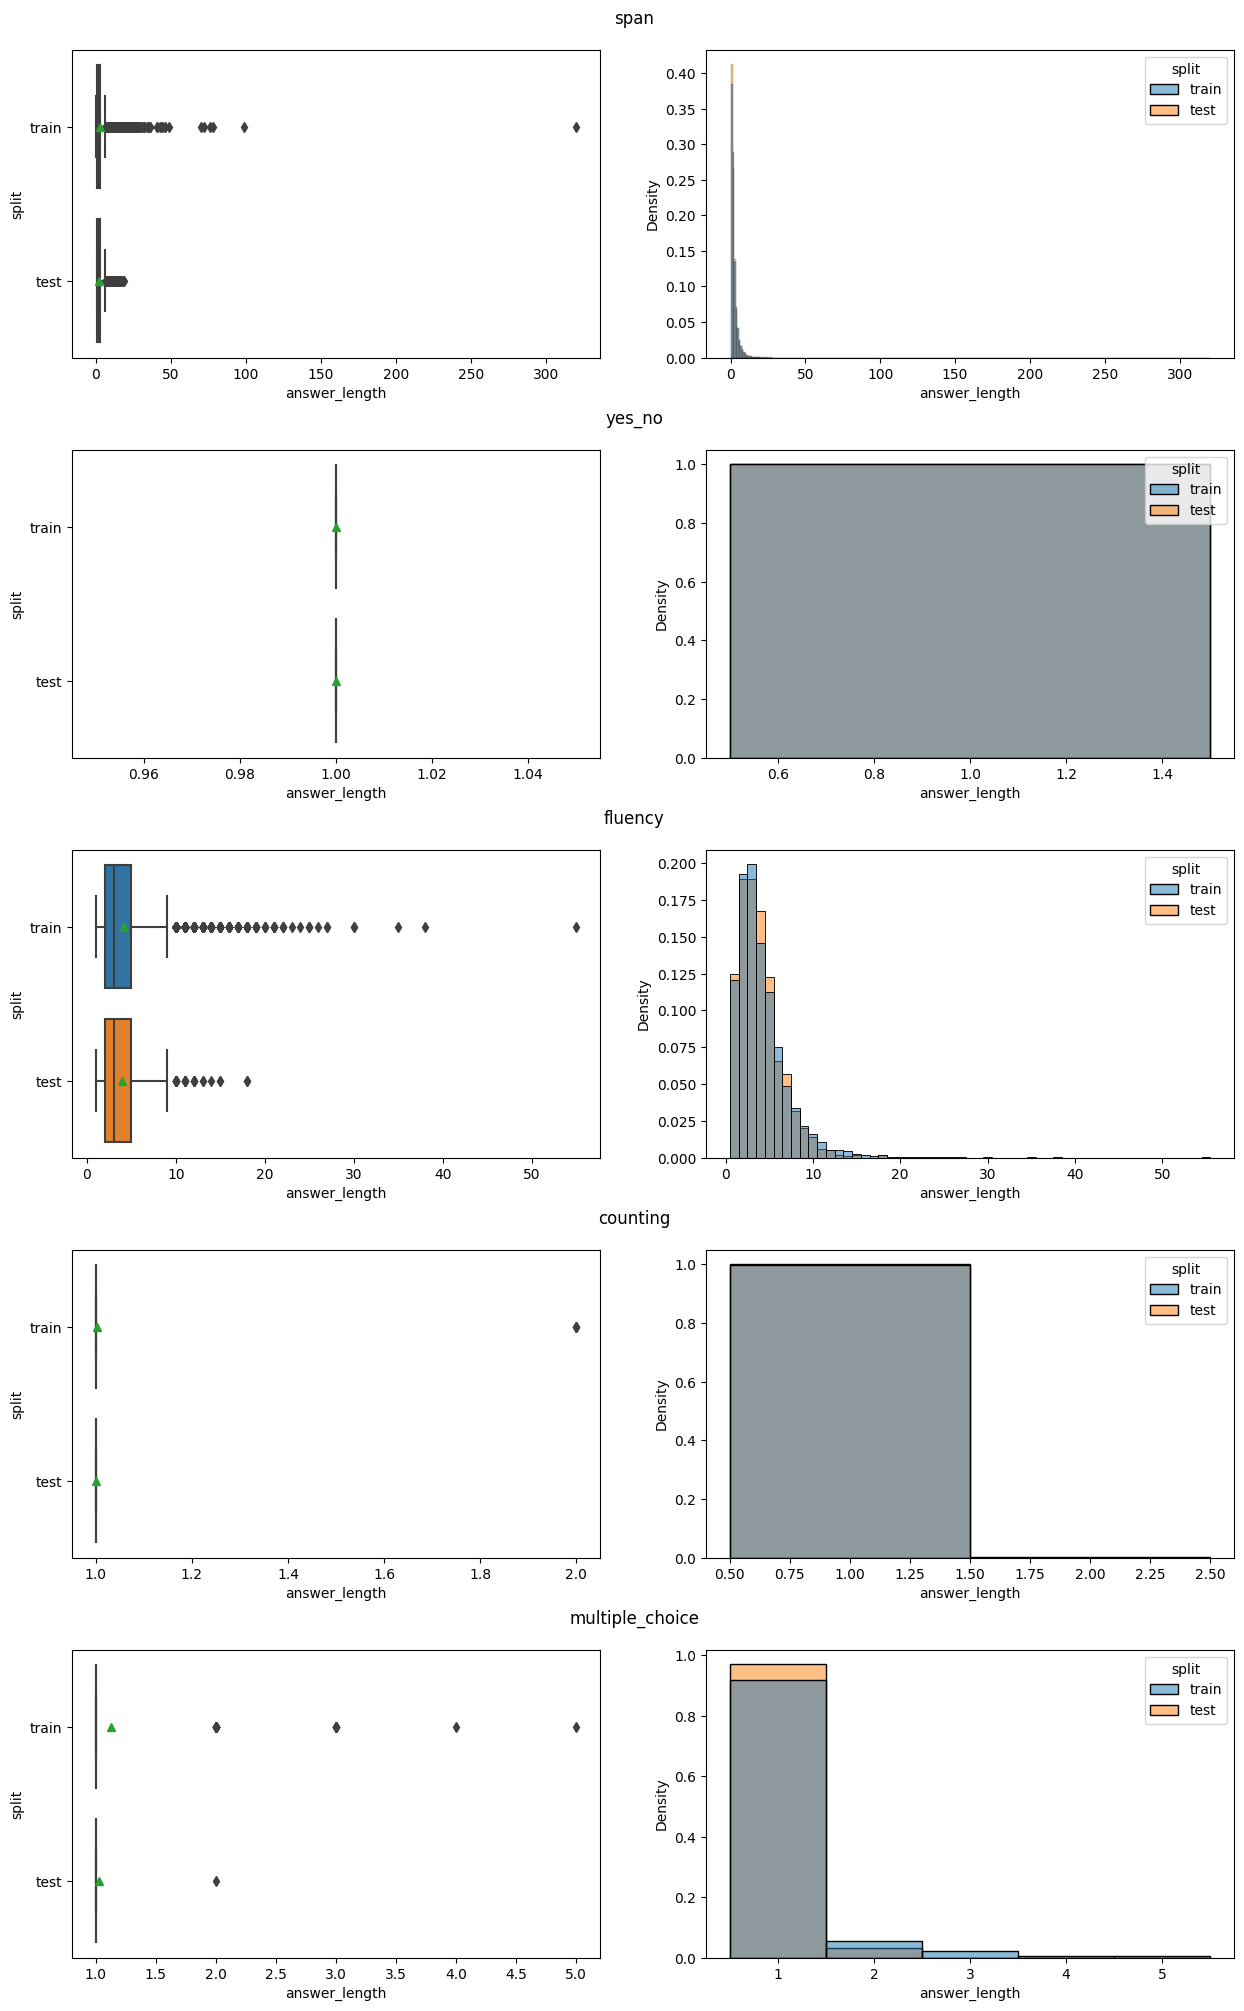

distil_roberta


answer_length                                          \
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train         946.0  1.047569  0.277669  1.0  1.0  1.0  1.0   
fluency         test         1003.0  4.707876  2.749961  1.0  3.0  4.0  6.0   
                train       13760.0  4.995712  3.377595  1.0  3.0  4.0  6.0   
multiple_choice test           33.0  1.303030  0.585494  1.0  1.0  1.0  1.0   
                train         262.0  1.309160  0.612632  1.0  1.0  1.0  1.0   
span            test         5192.0  3.524076  2.578118  1.0  2.0  3.0  4.0   
                train       71348.0  3.714596  3.279046  0.0  2.0  3.0  5.0   
yes_no          test         1619.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train       20970.0  1.000000  0.000000  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    4.0  
fluency         test    21.0  
                train   59.0  
multiple_choice test     3.0  
                train    5.0  
span            test    37.0  
                train  337.0  
yes_no          test     1.0  
                train    1.0

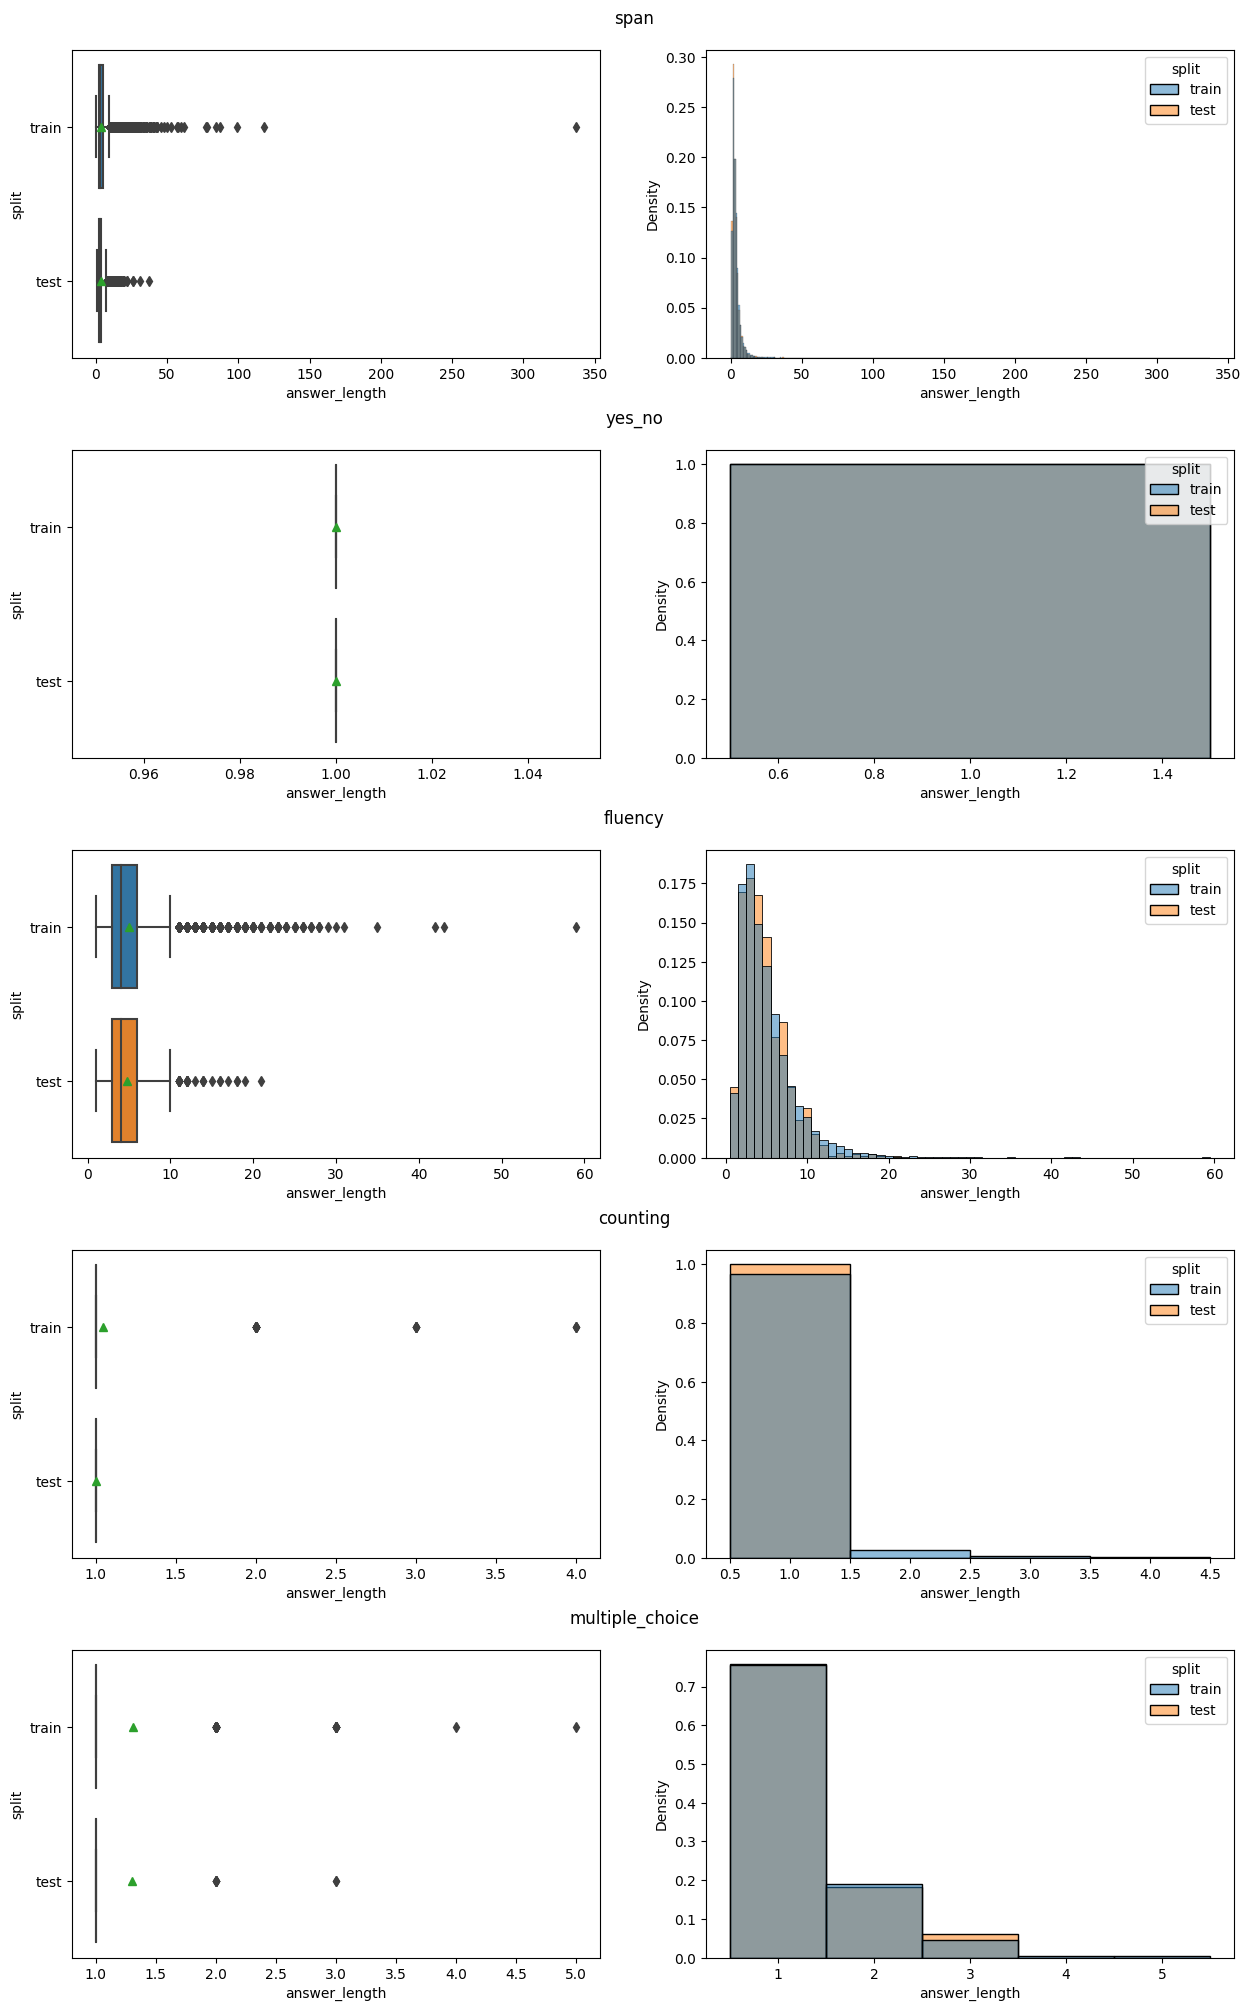

bert_tiny


answer_length                                          \
                              count      mean       std  min  25%  50%  75%   
answer_type     split                                                         
counting        test           71.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train         946.0  1.032770  0.251943  1.0  1.0  1.0  1.0   
fluency         test         1003.0  4.344965  2.659041  1.0  2.0  4.0  6.0   
                train       13760.0  4.591352  3.239559  1.0  2.0  4.0  6.0   
multiple_choice test           33.0  1.060606  0.242306  1.0  1.0  1.0  1.0   
                train         262.0  1.156489  0.512615  1.0  1.0  1.0  1.0   
span            test         5192.0  2.875963  2.377012  1.0  1.0  2.0  4.0   
                train       71348.0  3.053260  3.087884  0.0  1.0  2.0  4.0   
yes_no          test         1619.0  1.000000  0.000000  1.0  1.0  1.0  1.0   
                train       20970.0  1.000000  0.000000  1.0  1.0  1.0  1.0   

                              
                         max  
answer_type     split         
counting        test     1.0  
                train    4.0  
fluency         test    20.0  
                train   60.0  
multiple_choice test     2.0  
                train    5.0  
span            test    28.0  
                train  323.0  
yes_no          test     1.0  
                train    1.0

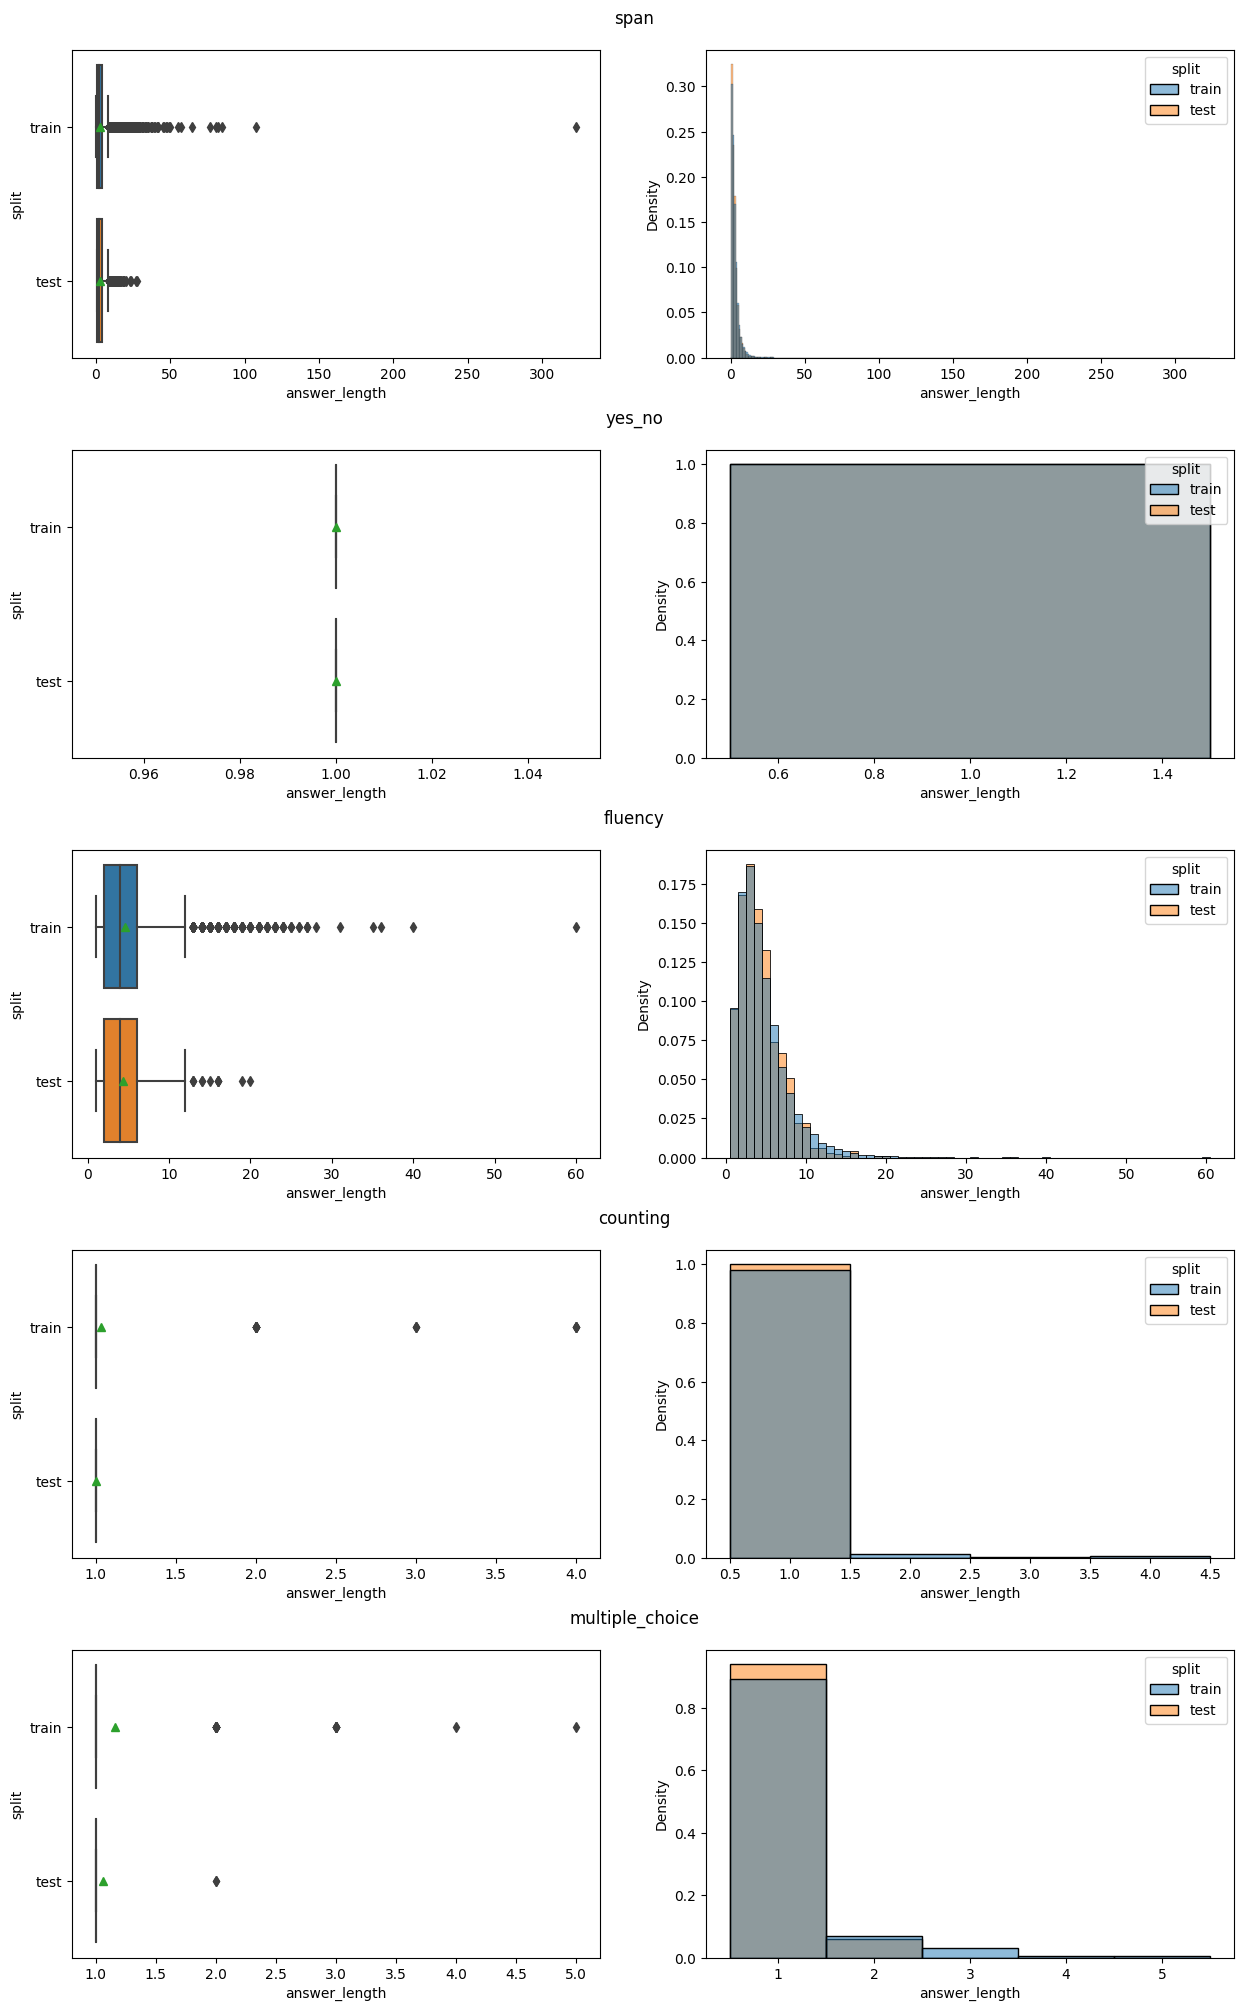

In [24]:
def plot_answer_length(dataset, split_fn=str.split, notes=None):
    length_col = "answer" + "_length"
    length = dataset["answer"].apply(split_fn).apply(len)
    dp = dataset[["answer_type", "split"]].copy()
    dp[length_col] = length

    if notes:
        print(notes)
    display(dp.groupby(["answer_type", "split"]).describe())

    answer_types = AnswerType.list(return_unknown=False)
    fig = plt.figure(figsize=(15, 4 * len(answer_types)))
    fig.suptitle(f"Answer length ({notes})", fontsize=16)

    subfigs = fig.subfigures(nrows=len(answer_types), ncols=1)
    for answer_type, subfig in zip(answer_types, subfigs):
        data = dp[dp["answer_type"] == answer_type]
        subfig.suptitle(answer_type)
        axes = subfig.subplots(1, 2)
        sns.boxplot(data=data,
                    x=length_col,
                    y="split",
                    showmeans=True,
                    ax=axes[0])
        sns.histplot(data,
                     x=length_col,
                     hue="split",
                     stat="density",
                     common_norm=False,
                     discrete=True,
                     ax=axes[1])
    plt.show()

qa_dataset["answer"] = qa_dataset["answer"].apply(normalize_answer)

for name, tokenize_fn in tokenizers.items():
    plot_answer_length(qa_dataset, split_fn=tokenize_fn, notes=name)

Let's inspect counting and multiple choice answers with more than one word.

In [25]:
def to_readable_question(question, answer, rationale, answer_type, turn=None):
    lines = []
    if turn is not None:
        lines.append(f'turn: {turn}')
    lines.append(f'Q\t\t{question} || {answer_type}')
    lines.append(f'A\t\t{answer} || {rationale}')

    return '\n'.join(lines)

def print_readable_questions(data: pd.DataFrame, show_turn=False):
    for _, row in data.iterrows():
        print("id:", row["id"])
        turn = row["turn"] if show_turn else None
        print(to_readable_question(row["question"], row["answer"], row["rationale"], row["answer_type"], turn=turn))
        print()

for answer_type in [AnswerType.COUNTING, AnswerType.MULTIPLE_CHOICE]:
    example = qa_dataset[np.logical_and(qa_dataset["answer_type"] == str(answer_type), qa_dataset["answer"].str.split().apply(len) > 1)]
    print(answer_type)
    print_readable_questions(example)
    print("="*100)

counting
id: 37fmassaycr9w4ms0qgefb1xykpiby
Q		How many petty princely states were absorbed into Himachal? || counting
A		twenty eight || 15 April 1948 as a result of integration of 28 petty princely states

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How old was he? || counting
A		twenty seven || age of 27

id: 3jwh6j9i9sd1a5xjx6t6kjxekp0nbc
Q		How many internationals goals did he have? || counting
A		twenty four ||  24 international goals 

multiple_choice
id: 3tr2532vipuzl3p3mhk6gwu5x1m6j2
Q		Is this story completly made up or based on real life events? || multiple_choice
A		real life events || true story, which he found in a memoir written by a man name

id: 3k3r2qnk8b3vh22vwnrw78ui4spu9e
Q		was instructed to go, or told to think about it? || multiple_choice
A		to think about it ||  I know she said that she would sooner that you were present than all her English friends together. However, you can think about it.

id: 3uxuoq9okex7oa04blcltbri2zna7k
Q		Did the larger one or smaller one get

Multiple choice answers are ok, while counting answers are just wrongly annotated. Indeed, they are span-based answers.

rationale_length                                                
                 count      mean       std  min  25%  50%   75%    max
split                                                                 
test            7918.0  9.133114  8.820682  1.0  4.0  7.0  12.0  268.0
train         107286.0  9.241252  9.257729  1.0  4.0  7.0  12.0  353.0

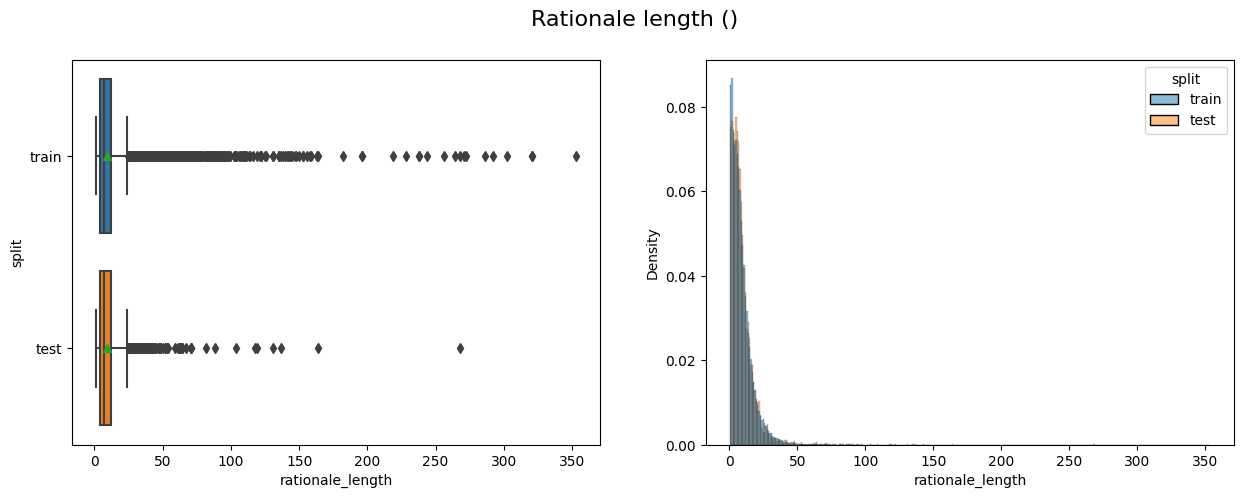

distil_roberta


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.755620  11.689437  1.0  5.0  9.0  15.0  414.0
train         107286.0  12.007997  12.147238  1.0  5.0  9.0  15.0  461.0

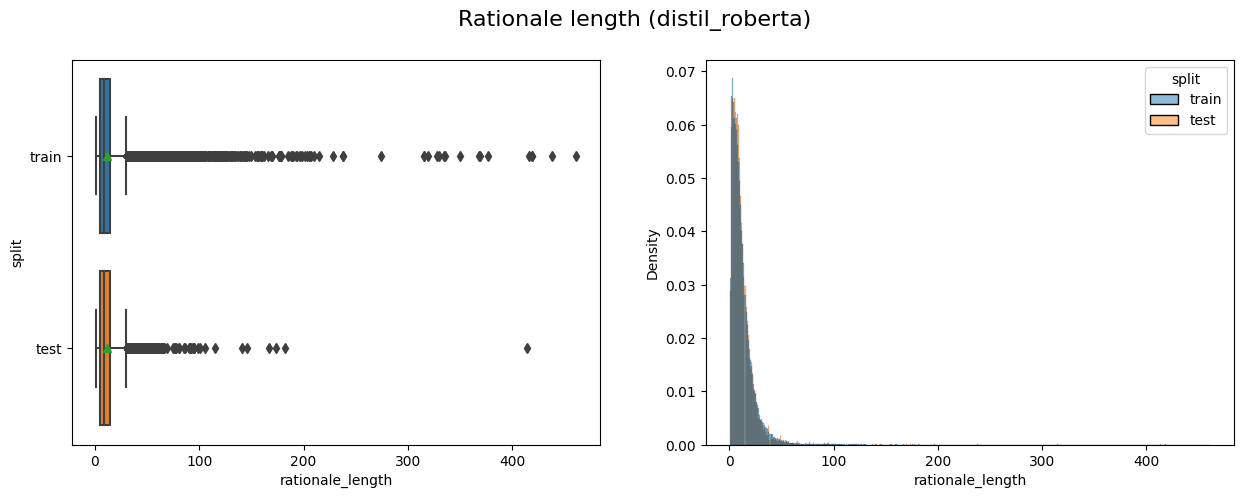

bert_tiny


rationale_length                                                  
                 count       mean        std  min  25%  50%   75%    max
split                                                                   
test            7918.0  11.437737  11.621558  1.0  5.0  9.0  15.0  402.0
train         107286.0  11.663283  12.094999  1.0  4.0  9.0  15.0  436.0

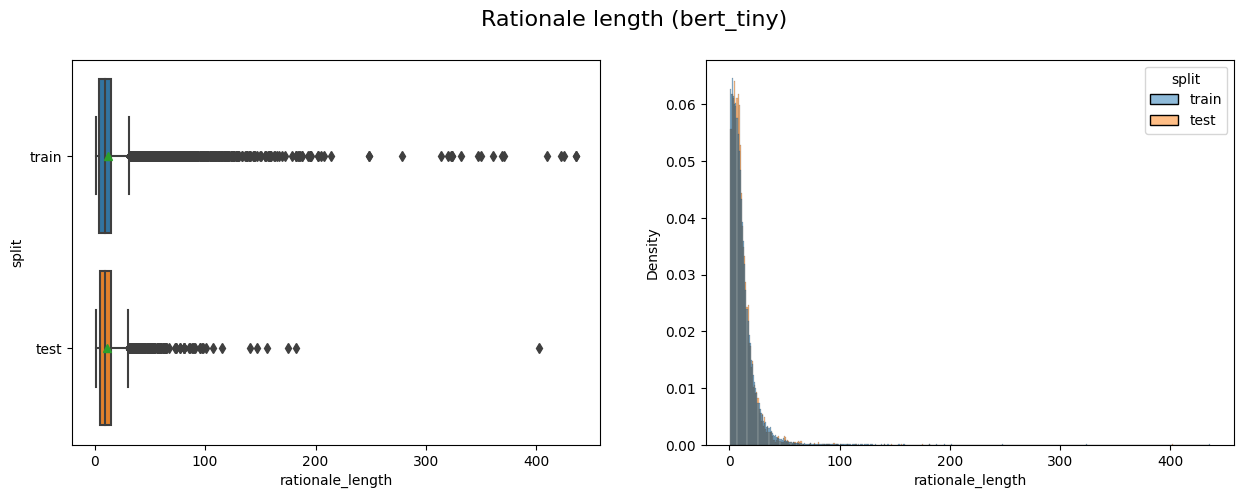

In [26]:
for name, tokenize_fn in tokenizers.items():
    plot_length(qa_dataset,
                column="rationale",
                split_fn=tokenize_fn,
                notes=name)

As we can see from the outputs below, very long rationales have no reason to be so lengthy. Indeed, it is likely to be a consequence of poor workmanship.

In [27]:
long_rationales = qa_dataset[qa_dataset["rationale"].str.split().apply(len) > 200]
print("Number of questions with very long rationale:", len(long_rationales))
print()
print_readable_questions(long_rationales)

Number of questions with very long rationale: 17

id: 3ohyz19ugc5e9gs3s7tn4xddsevoa2
Q		Where? || span
A		missouri || Hannibal, Missouri, located on the west bank of the Mississippi. Twain grew up there and was fascinated with (......) life along the river----the steamboats, the giant lumber rafts, and the people who worked on them. 

The Celebrated Jumping Frog of Calaveras County is one of Twain's best loved short stories, and The Adventures of Tom Sawyer is one of his most famous novels. Both these works are celebrated by events held during National Tom Sawyer Days, which originated in the late 1950s and became national in the 1960s. Children enter their frogs in the jumping contest during National Tom Sawyer Days. There's also a fence painting contest to see who can paint the fastest. The idea for this contest comes from a scene in Tom Sawyer, in which Tom has been told to paint the fence in front of the house he lives in. It's a beautiful day, and he would rather be doing anything

In [28]:
example = qa_dataset[qa_dataset["rationale"] == qa_dataset["story"]]
print("Number of questions with rationale equal to the whole passage:", len(example))
print()
print_readable_questions(example)

Number of questions with rationale equal to the whole passage: 11

id: 3vj40nv2qinjocrcy7k4z235f4yot6
Q		DId someone want to put olives on it? || yes_no
A		no || The children's father wanted to know what every one wanted on their pizza. Andy wanted a strawberry on his pizza. Father thought that was funny. Father asked if anyone wanted chicken on the pizza. Sue did not want chicken. Andy wanted chicken. Dan did not want chicken, but their father wanted to get chicken on the pizza. Dan asked if they could have mushrooms on the pizza. Father did not like mushrooms. Andy and Sue wanted to have mushrooms, so their father had them put mushrooms on the pizza. Sue wanted to have green onions on the pizza. Father also wanted green onions. Dan and Andy did not like green onions, so they did not get green onions on the pizza. Father wanted to order thin crust pizza. Dan thought that thin crust pizza had the taste of an old shoe. Sue thought Dan was wrong. Sue wanted thin crust pizza also. Andy wa

Upon further analysis of the corpus, we observed instances where words at the beginning or at the end of the rationale are truncated. Therefore, we have to fix them if we intend to use the rationale to train the network.

In [29]:
def print_rationales(data: pd.DataFrame):
    for i, row in data.iterrows():
        print("id:", row["id"], "split:", row["split"])
        print("turn:", row["turn"])
        print("R:", row["rationale"], "|", row["span_start"], "-", row["span_end"])
        print("="*100)

def is_rationale_truncated(passage, span_start, span_end):
    if span_start > 0 and passage[span_start].isalnum() and passage[span_start -1].isalnum():
        return True
    
    if span_end < len(passage) and passage[span_end - 1].isalnum() and passage[span_end].isalnum():
        return True
    
    return False

example = qa_dataset[qa_dataset.apply(lambda row: is_rationale_truncated(row["story"], row["span_start"], row["span_end"]), axis=1)]
print("Number of rationales with errors:", len(example), "/", len(qa_dataset))
print()
print_rationales(example)

Number of rationales with errors: 5572 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R: he Vatican Library is a research library | 454 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R: Scholars have traditionally divided the history of the library into five period | 1048 - 1127
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 11
R: atican Secret Archives were separated from the library at the beginning of the 17th century; | 917 - 1009
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 16
R: hotocopies for private study of pages from books published between 1801 and 1990 | 644 - 724
id: 3bdcf01ogxu7zdn9vlrbf2rqzwplyf split: train
turn: 11
R: the need of a helper, of a friend, of a champio | 751 - 798
id: 3urfvvm165iantk80llvkwwbjs7uzh split: train
turn: 3
R:  Valentina was very pale, and round her eyes there were dark circles that told of sleeplessness, and as she bowed her head in prayer, her ladies observed that tears were falling on the ill

In order to solve the issue, we have to:
1. remove any leading or trailing non alphanumeric character (i.e. spaces, punctuation, etc.) from the rationale.
2. compute new `span_start` and `span_end` indices by considering the entire words.

In [30]:
#1. removing leading and trailing non alphanumeric chars
example = " Despite a common background, the groups' views on religious toleration were mixe."
print("Before:", example)
print("After:", strip_non_alphanumeric_chars(example))

Before:  Despite a common background, the groups' views on religious toleration were mixe.
After: Despite a common background, the groups' views on religious toleration were mixe


In [31]:
qa_dataset_fixed = qa_dataset.copy()
qa_dataset_fixed["rationale"] = qa_dataset_fixed["rationale"].apply(strip_non_alphanumeric_chars)
n_affected_rationales = np.count_nonzero(qa_dataset_fixed["rationale"] != qa_dataset["rationale"])
print("Number of affected rationales:", n_affected_rationales, "/", len(qa_dataset))

Number of affected rationales: 55649 / 115204


In [32]:
#2. compute span_start and span_end indices by considering the entire words.
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = "e Vatican Library is a research lib"
span_start, span_end = find_span(passage, rationale)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "The Vatican Library is a research library"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

print()

passage = " Mandi Marie Utash posted Friday to a GoFundMe.com page [...]\nMandi Marie Utash\twrote that her father doesn't seem to know what happened"
rationale = "andi Marie Utas"
span_start, span_end = find_span(passage,
                                 rationale,
                                 span_start=63,
                                 span_end=78)
fixed_rationale = passage[span_start:span_end]
assert fixed_rationale == "Mandi Marie Utash"

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-): e Vatican Library is a research lib
R (+): The Vatican Library is a research library | 1 - 42

P:  Mandi Marie Utash posted Friday to a GoFundMe.com page [...]
Mandi Marie Utash	wrote that her father doesn't seem to know what happened
R (-): andi Marie Utas
R (+): Mandi Marie Utash | 62 - 79


In [33]:
# Fix rationale by applying (1) and (2)
passage = "\tThe Vatican Library is a research library for history, law, philosophy, science and theology."
rationale = " e Vatican Library is a research library for history,  "
fixed_rationale, span_start, span_end = fix_rationale(passage, rationale, 1, 100)

print("P:", passage)
print("R (-):", rationale)
print("R (+):", fixed_rationale, "|", span_start, "-", span_end)
assert fixed_rationale == "The Vatican Library is a research library for history"

P: 	The Vatican Library is a research library for history, law, philosophy, science and theology.
R (-):  e Vatican Library is a research library for history,  
R (+): The Vatican Library is a research library for history | 1 - 54


In [34]:
def _fix_rationale(row):
    fixed_rationale, span_start, span_end = fix_rationale(
        row["story"], row["rationale"], row["span_start"], row["span_end"])

    row["rationale"] = fixed_rationale
    row["span_start"] = span_start
    row["span_end"] = span_end

    return row


qa_dataset_fixed = qa_dataset.apply(_fix_rationale, axis=1)
diff_start = qa_dataset_fixed["span_start"] != qa_dataset["span_start"]
diff_end = qa_dataset_fixed["span_end"] != qa_dataset["span_end"]
diff_rationale = qa_dataset_fixed["rationale"] != qa_dataset["rationale"]

assert np.all((diff_start | diff_end) == diff_rationale)

example = qa_dataset_fixed[diff_rationale]
print("Number of fixed rationales:", len(example), "/", len(qa_dataset))
print()
for i, row in example.iloc[:100].iterrows():
    old_row = qa_dataset[(qa_dataset["id"] == row["id"]) & (qa_dataset["turn"] == row["turn"])]
    assert len(old_row) == 1
    old_row = old_row.iloc[0]

    print("id:", row["id"], "split:", row["split"])
    print("turn:", row["turn"])
    print("R (-):", old_row["rationale"], "|", old_row["span_start"], "-", old_row["span_end"])
    print("R (+):", row["rationale"], "|", row["span_start"], "-", row["span_end"])
    print("="*100)

qa_dataset = qa_dataset_fixed
del qa_dataset_fixed

Number of fixed rationales: 58992 / 115204

id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 2
R (-): he Vatican Library is a research library | 454 - 494
R (+): The Vatican Library is a research library | 453 - 494
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 6
R (-): Scholars have traditionally divided the history of the library into five period | 1048 - 1127
R (+): Scholars have traditionally divided the history of the library into five periods | 1048 - 1128
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 8
R (-): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat,  | 4 - 94
R (+): Vatican Apostolic Library (), more commonly called the Vatican Library or simply the Vat | 4 - 92
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train
turn: 9
R (-): is the library of the Holy See, located in Vatican City. | 94 - 150
R (+): is the library of the Holy See, located in Vatican City | 94 - 149
id: 3zotghdk5ibi9cex97fepx7jetpso7 split: train

The type of answers are equally distributed across datasets.

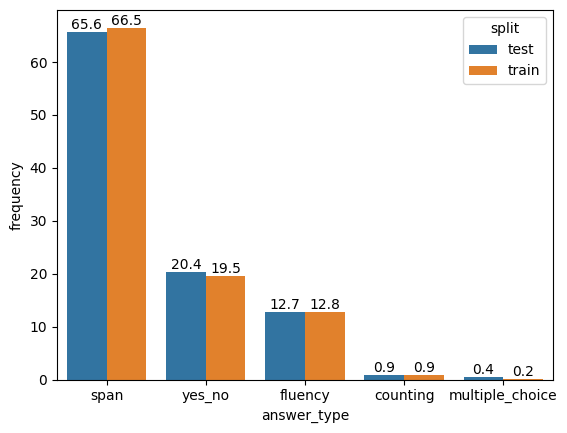

In [39]:
plot_answer_type_distribution(qa_dataset)

In [40]:
for answer_type in AnswerType.list(return_unknown=False):
    example = qa_dataset[qa_dataset["answer_type"] == answer_type].sample(3)
    print(answer_type)
    print()
    print_readable_questions(example)
    print("=" * 100)

span

id: 3qrymnz7fyh16rr0xskrkd30q1ont0
Q		When did the new agency begin operation? || span
A		october 1 1958 || The new agency became operational on October 1, 1958

id: 3qapzx2qn4d41w5gd7yx8eyxhhm205
Q		How old was he? || span
A		33 || 33

id: 3jnqlm5ft4mhysu220kg6yqllvj2lx
Q		Who is the other? || span
A		lightfoot || Lightfoot

yes_no

id: 39owyr0epkrlzldd9aodkpm63e3fyx
Q		Could they enter the cottage? || yes_no
A		yes || We entered the cottage

id: 3ctoc39k37qip3385rpymau1s9p7jf
Q		does that inlcude KU? || yes_no
A		yes || is one of the 62 members

id: 3velcll3gkjo9f2axlh462bwves1fo
Q		Did it happen during the game? || yes_no
A		no || during a rain delay in the game

fluency

id: 3zv9h2yqqd7mu42kae5nyjcto0xw38
Q		What was his realization? || fluency
A		that he needed to do them all || I looked at my wife and told her what happened and said, 'Now we need to do them all

id: 369j354ofdapu1z2ebz3jj2p43ag60
Q		Who is back where he feels comfortable? || fluency
A		rafael nadal is comfo

In [42]:
del qa_dataset

# [Task 2] Train, test and validation split

In [70]:
raw_dataset = datasets.load_from_disk(CONFIG.dataset.processed_dir)
print(raw_dataset)

DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 7193
    })
    test: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


In [71]:
train_data = raw_dataset["train"]
test_data = raw_dataset["test"]
raw_dataset = train_data.train_test_split(train_size=0.8, seed=42)
raw_dataset["validation"] = raw_dataset.pop("test")
raw_dataset["test"] = test_data

print(raw_dataset)

Loading cached split indices for dataset at d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\data\processed\train\cache-997023823fd25bd2.arrow and d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\data\processed\train\cache-c35f5186c7c96ca6.arrow


DatasetDict({
    train: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 5754
    })
    validation: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 1439
    })
    test: Dataset({
        features: ['source', 'id', 'filename', 'story', 'questions', 'answers', 'name', 'qa_length', 'last_turn'],
        num_rows: 500
    })
})


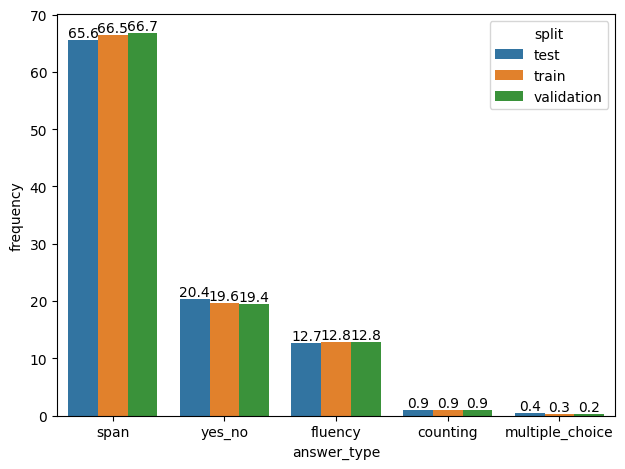

In [72]:
df = create_dataframe(raw_dataset)
qa_dataset = explode_qa(df)
plot_answer_type_distribution(qa_dataset)

del qa_dataset

# [Task 3] Model definition

tensor(3., grad_fn=<SumBackward0>)


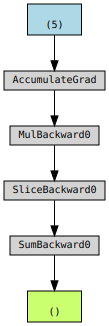

In [ ]:
# wr = torch.tensor([0.5, 0.2, 0.6, 0.1, 0.1], requires_grad=True)
# ws = torch.tensor([0.8, 0.2, 0.3, 0.1, 0.1], requires_grad=True)
# we = torch.tensor([0.2, 0.1, 0.1, 0.8, 0.1], requires_grad=True)

# r = wr * 6
# ps = ws * r
# pe = we * r

# start = torch.argmax(ps)
# end = torch.argmax(pe)
# R = r[start: end+1]


# y = R.sum()
# y.backward()

# print(y)

# make_dot(y)

tensor([1.0000, 1.0000, 1.0000, 1.2800, 0.0800], grad_fn=<MaskedFillBackward0>)
tensor([0.5000, 0.8000, 0.9000, 2.0480, 0.0080], grad_fn=<MulBackward0>)
tensor(4.2560, grad_fn=<SumBackward0>)
tensor([5.0000, 4.0000, 3.0000, 5.1200, 0.1600])


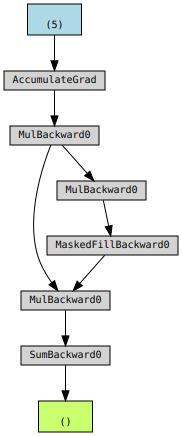

In [ ]:
# from torchviz import make_dot
# token_type_ids = torch.Tensor([0, 0, 0, 1, 1])
# w = torch.tensor([0.1, 0.2, 0.3, 0.8, 0.1], requires_grad=True)
# hidden_states = w * torch.Tensor([5, 4, 3, 2, 1])
# p_token = hidden_states * 0.8
# p_token = p_token.masked_fill(~token_type_ids.bool(), 1)
# print(p_token)
# y = p_token * hidden_states

# # external_grad = torch.ones_like(y)
# # y.backward(gradient=external_grad)
# print(y)
# y = y.sum()
# y.backward()

# print(y)
# print(w.grad)

# make_dot(y)

In [ ]:
class QAEncoderDecoderModel(transformers.EncoderDecoderModel):

    def __init__(
        self,
        encoder: transformers.PreTrainedModel,
        decoder: transformers.PreTrainedModel,
        config: Optional[transformers.PretrainedConfig] = None,
    ):
        super(QAEncoderDecoderModel, self).__init__(encoder=encoder,
                                                    decoder=decoder,
                                                    config=config)

    def tie_weights(self):
        # tie encoder & decoder if needed
        if self.config.tie_encoder_decoder:
            # tie encoder and decoder base model
            encoder_base_model_prefix = self.encoder.base_model_prefix
            decoder_base_model_prefix = self.decoder.base_model_prefix
            self._tie_encoder_decoder_weights(
                self.encoder._modules[encoder_base_model_prefix],
                self.decoder._modules[decoder_base_model_prefix],
                self.decoder.base_model_prefix)

    def forward(
        self,
        input_ids: Optional[torch.LongTensor] = None,
        token_type_ids: Optional[torch.LongTensor] = None,
        attention_mask: Optional[torch.FloatTensor] = None,
        passage_mask: Optional[torch.LongTensor] = None,
        decoder_input_ids: Optional[torch.LongTensor] = None,
        decoder_attention_mask: Optional[torch.BoolTensor] = None,
        encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
        past_key_values: Tuple[Tuple[torch.FloatTensor]] = None,
        inputs_embeds: Optional[torch.FloatTensor] = None,
        decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
        labels: Optional[torch.LongTensor] = None,
        use_cache: Optional[bool] = None,
        output_attentions: Optional[bool] = None,
        output_hidden_states: Optional[bool] = None,
        return_dict: Optional[bool] = None,
        **kwargs
    ) -> Union[Tuple, transformers.modeling_outputs.Seq2SeqLMOutput]:
        return super().forward(input_ids,
                               attention_mask,
                               decoder_input_ids,
                               decoder_attention_mask,
                               encoder_outputs,
                               past_key_values,
                               inputs_embeds,
                               decoder_inputs_embeds,
                               labels,
                               use_cache,
                               output_attentions,
                               output_hidden_states,
                               return_dict,
                               token_type_ids=token_type_ids,
                               passage_mask=passage_mask,
                               **kwargs)


class BertRationaleEncoder(transformers.PreTrainedModel):
    base_model_prefix = "encoder"

    # supports_gradient_checkpointing = True

    def __init__(self, encoder, config) -> None:
        # self.config_class = self.encoder.config_class
        # self._init_weights = self.encoder._init_weights
        # self._set_gradient_checkpointing = self.encoder._set_gradient_checkpointing
        # self._keys_to_ignore_on_load_missing = self.encoder._keys_to_ignore_on_load_missing

        super().__init__(config)
        self.config = config

        self.encoder = encoder
        classifier_dropout = (config.classifier_dropout
                              if config.classifier_dropout is not None else
                              config.hidden_dropout_prob)
        self.rationale_dropout = nn.Dropout(classifier_dropout)
        self.rationale_head = BertTokenSelectionHead(config)

        # self.ynr_dropout = nn.Dropout(classifier_dropout)
        # self.proj_ynr = nn.Linear(config.hidden_size, 3, bias=True)

        # Initialize weights and apply final processing
        # self.post_init()

    def forward(self,
                input_ids: Optional[torch.Tensor] = None,
                attention_mask: Optional[torch.Tensor] = None,
                inputs_embeds: Optional[torch.FloatTensor] = None,
                passage_mask: Optional[torch.Tensor] = None,
                output_attentions: Optional[bool] = None,
                output_hidden_states: Optional[bool] = None,
                return_dict: Optional[bool] = None,
                **kwargs) -> Tuple[torch.Tensor]:
        assert passage_mask is not None

        outputs = self.encoder(input_ids=input_ids,
                               attention_mask=attention_mask,
                               inputs_embeds=inputs_embeds,
                               output_attentions=output_attentions,
                               output_hidden_states=output_hidden_states,
                               return_dict=return_dict,
                               **kwargs)

        last_hidden_state = outputs[0]
        pooled_output = outputs[1]

        sequence_output = self.rationale_dropout(last_hidden_state)
        p_token = self.rationale_head(sequence_output)
        p_token = p_token.masked_fill(~passage_mask.unsqueeze(-1).bool(), 1)
        last_hidden_state = last_hidden_state * p_token

        # loss = None
        # if labels is not None:
        #     loss_fct = CrossEntropyLoss()
        #     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # TODO: remove pooled_output if yes_no_head is not used
        if not return_dict:
            return (last_hidden_state, pooled_output) + outputs[2:]

        return transformers.modeling_outputs.BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


class BertTokenSelectionHead(nn.Module):

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size,
                               config.hidden_size,
                               bias=True)
        if isinstance(config.hidden_act, str):
            self.act_fn = transformers.modeling_utils.get_activation(
                config.hidden_act)
        else:
            self.act_fn = config.hidden_act
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.act_fn(hidden_states)
        logits = self.hidden_to_logit(hidden_states)
        p_token = self.sigmoid(logits)
        return p_token


def make_encoder_decoder_model(checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoder = AutoModel.from_pretrained(checkpoint)
    encoder = BertRationaleEncoder(encoder, encoder.config)
    decoder = transformers.AutoModelForCausalLM.from_pretrained(
        checkpoint,
        is_decoder=True,
        add_cross_attention=True,
        decoder_start_token_id=tokenizer.cls_token_id)

    config = transformers.EncoderDecoderConfig.from_encoder_decoder_configs(
        encoder.config,
        decoder.config,
        tie_encoder_decoder=True,
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.cls_token_id,
        eos_token_id=tokenizer.sep_token_id,
        vocab_size=decoder.config.vocab_size,
        max_length=64,
        min_length=2,
        finetuning_task=True,
        no_repeat_ngram_size=3,
        repetition_penalty=3.0,
        num_beams=10)

    model = QAEncoderDecoderModel(encoder=encoder,
                                  decoder=decoder,
                                  config=config)

    return tokenizer, model


k, model = make_encoder_decoder_model(BERT_TINY)
print(model)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

QAEncoderDecoderModel(
  (encoder): BertRationaleEncoder(
    (encoder): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(30522, 128, padding_idx=0)
        (position_embeddings): Embedding(512, 128)
        (token_type_embeddings): Embedding(2, 128)
        (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=128, out_features=128, bias=True)
                (key): Linear(in_features=128, out_features=128, bias=True)
                (value): Linear(in_features=128, out_features=128, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=128, out_features=128, bias

# [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$, we want $f_\theta(P, Q_i) \approx A_i$.

- Our question-answering model requires two inputs: the passage $P$ and the question $Q_i$.
- The model generates the answer $A_i$.


To facilitate easy access to these inputs and outputs, we need to organize our dataset accordingly.

In [ ]:
# def parse_question(question_item: dict):
#     return {
#         "turn": question_item["turn_id"],
#         "text": question_item["input_text"],
#         "question_type": question_item["answer_type"]
#     }


# def parse_answer(answer_item: dict):
#     return {
#         "turn": answer_item["turn_id"],
#         "text": answer_item["input_text"],
#         "rationale": answer_item["span_text"],
#         "span_start": answer_item["span_start"],
#         "span_end": answer_item["span_end"],
#         "answer_type": answer_item["answer_type"]
#     }

In [ ]:
max_length = 384
stride = 128

def create_dataloader(dataset: datasets.Dataset, tokenizer: transformers.PreTrainedTokenizer, max_length=512, stride=190):
    def preprocess_training_examples(examples):
        
        
    def tokenize(examples):
        return   tokenizer(
            examples["question"],
            examples["passage"],
            max_length=max_length,
            truncation="only_second",
            # stride=stride,
            # return_overflowing_tokens=True,
            # return_offsets_mapping=True,
            padding="max_length",
        )
    
    def preprocess_training_examples(examples):
        questions = [q.strip() for q in examples["question"]]
        inputs = 

        offset_mapping = inputs.pop("offset_mapping")
        sample_map = inputs.pop("overflow_to_sample_mapping")
        answers = examples["answers"]
        start_positions = []
        end_positions = []

        for i, offset in enumerate(offset_mapping):
            sample_idx = sample_map[i]
            answer = answers[sample_idx]
            start_char = answer["answer_start"][0]
            end_char = answer["answer_start"][0] + len(answer["text"][0])
            sequence_ids = inputs.sequence_ids(i)

            # Find the start and end of the context
            idx = 0
            while sequence_ids[idx] != 1:
                idx += 1
            context_start = idx
            while sequence_ids[idx] == 1:
                idx += 1
            context_end = idx - 1

            # If the answer is not fully inside the context, label is (0, 0)
            if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
                start_positions.append(0)
                end_positions.append(0)
            else:
                # Otherwise it's the start and end token positions
                idx = context_start
                while idx <= context_end and offset[idx][0] <= start_char:
                    idx += 1
                start_positions.append(idx - 1)

                idx = context_end
                while idx >= context_start and offset[idx][1] >= end_char:
                    idx -= 1
                end_positions.append(idx + 1)

        inputs["start_positions"] = start_positions
        inputs["end_positions"] = end_positions
        return inputs


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = k(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

'input_ids'

# [Task 5]

- Our question-answering model requires three inputs: the passage $P$, the question $Q_i$ and, possibly, the history $H=\left(Q_1, A_1, ..., Q_{i-1}, A_{i-1}\right)$.
- The model generates the answer $A_i$.

To facilitate easy access to these inputs and outputs, we need to organize our dataset accordingly.

In [ ]:
class TokenizedDataset(Dataset):

    def __init__(self, df, tokenizer, encoder_max_len=512, decoder_max_len=64):
        super(TokenizedDataset).__init__()
        self.df = df
        self.tokenizer = tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        # history = row.history
        question = row.question
        answer = row.answer
        rationale = row.rationale

        start_idx = row.span_start
        end_idx = row.span_end

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]*
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            'token_type_ids':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            'passage_mask':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            # #rationale
            # 'rat_start_idx':
            # torch.tensor(start_idx, dtype=torch.int64),
            # 'rat_end_idx':
            # torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

In [ ]:
def unpack_qna(df, history_len):
    unpacked_df = []

    for _, row in df.iterrows():
        history = ''
        qa_pairs = list(zip(row['questions'], row['answers']))
        for idx, (question, answer) in enumerate(qa_pairs):
            history = ''.join([
                qa_pairs[i][0]['text'] + ' ' +
                qa_pairs[i][1]['text'] + '. '
                for i in range(max(0, idx - history_len), idx)
            ])
            data = {
                'source': row['source'],
                'passage': row['passage'],
                'question': question['text'],
                'answer': answer['text'],
                'rationale': answer['rationale'],
                'span_start': answer['span_start'],
                'span_end': answer['span_end'],
                'history': history
            }
            unpacked_df.append(data)

    unpacked_df = pd.DataFrame(unpacked_df)
    unpacked_df.reset_index(drop=True, inplace=True)

    return unpacked_df

df_train, df_val = train_test_split(df[df['split'] == 'train'], train_size=0.8, random_state=42)
df_val['split'] = 'val'
df_test = df[df['split'] == 'test']

df_train.reset_index(drop=True, inplace=True)
df_val.reset_index(drop=True, inplace=True)
df_test.reset_index(drop=True, inplace=True)

print(f"Train shape: {df_train.shape}")
print(f"  Val shape: {df_val.shape}")
print(f" Test shape:  {df_test.shape}")

train_data = unpack_qna(df_train, 3).sample(1024)
val_data = unpack_qna(df_val, 3).sample(1024)
test_data = unpack_qna(df_test, 3).sample(1024)

Train shape: (5754, 9)
  Val shape: (1439, 9)
 Test shape:  (500, 9)


In [ ]:
def train_model(model,
                train_dataset,
                val_dataset,
                epochs=3,
                save_path="bert_tiny"):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Creating datasets...")

    # Prepare DataLoaders
    print("Creating dataloaders...")
    train_loader = create_reproducible_dataloader(train_dataset,
                              batch_size=32,
                              drop_last=False,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True
                              )
    val_loader = create_reproducible_dataloader(val_dataset,
                            batch_size=32,
                            drop_last=False,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=True
                            )

    optimizer = AdamW(model.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    print("Training...")
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        # for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        for idx, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)

            loss = model(**inputs, labels=labels).loss

            epoch_loss += loss.item()
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)

                # Forward pass
                loss = model(**inputs, labels=labels).loss

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )

    if save_path is not None:
        torch.save(model, save_path)
        del model

    return train_loss, val_loss

# generative_model = GenerativeModel('BERTTiny', "prajjwal1/bert-tiny", device=device)
k, model = make_encoder_decoder_model(BERT_TINY)
dataset = TokenizedDataset(train_data, k)
val_dataset = TokenizedDataset(val_data, k)
history = train_model(model, dataset, val_dataset)
# history = train_model(M2, train_test, val_test)
print("Train complete")

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

Creating datasets...
Creating dataloaders...
Training...


In [ ]:
# max_length = 384
# stride = 128


# def preprocess_training_examples(examples):
#     questions = [q.strip() for q in examples["question"]]
#     inputs = tokenizer(
#         questions,
#         examples["context"],
#         max_length=max_length,
#         truncation="only_second",
#         stride=stride,
#         return_overflowing_tokens=True,
#         return_offsets_mapping=True,
#         padding="max_length",
#     )

#     offset_mapping = inputs.pop("offset_mapping")
#     sample_map = inputs.pop("overflow_to_sample_mapping")
#     answers = examples["answers"]
#     start_positions = []
#     end_positions = []

#     for i, offset in enumerate(offset_mapping):
#         sample_idx = sample_map[i]
#         answer = answers[sample_idx]
#         start_char = answer["answer_start"][0]
#         end_char = answer["answer_start"][0] + len(answer["text"][0])
#         sequence_ids = inputs.sequence_ids(i)

#         # Find the start and end of the context
#         idx = 0
#         while sequence_ids[idx] != 1:
#             idx += 1
#         context_start = idx
#         while sequence_ids[idx] == 1:
#             idx += 1
#         context_end = idx - 1

#         # If the answer is not fully inside the context, label is (0, 0)
#         if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
#             start_positions.append(0)
#             end_positions.append(0)
#         else:
#             # Otherwise it's the start and end token positions
#             idx = context_start
#             while idx <= context_end and offset[idx][0] <= start_char:
#                 idx += 1
#             start_positions.append(idx - 1)

#             idx = context_end
#             while idx >= context_start and offset[idx][1] >= end_char:
#                 idx -= 1
#             end_positions.append(idx + 1)

#     inputs["start_positions"] = start_positions
#     inputs["end_positions"] = end_positions
#     return inputs

In [ ]:
t = AutoTokenizer.from_pretrained(DISTIL_ROBERTA)
t._tokenizer.post_processor

inputs = t(question, passage)
t.decode(inputs["input_ids"])

"<s>What did Jack's dad do for a living?</s></s>Jack Johnson is one of the most popular singer-songwriters in the world. Jack was born on May 18, 1975 in Hawaii. Being the son of a famous surfer, Jack naturally has an interest in surfing. Most of his life lessons were learned in the water. At the age of 17, Jack entered the finals of the Pineline Masters---the world's most famous surfing competition. Everyone thought Jack would become a professional surfer like his father. Unluckily, one month later, he had a deadly accident while surfing and was seriously hurt. Life is like a revolving door. When it closes, it also opens. Jack started to practice playing the guitar and write songs when he was staying in hospital. At first, his father thought Jack only did it for fun, but soon he was surprised at the great progress his son had made. When studying in the university, Jack didn't stop practicing his guitar skills. He played the guitar for school parties. He wrote songs and sang for his te

In [ ]:
k = AutoTokenizer.from_pretrained(BERT_TINY)
passage = dataset["train"][0]["passage"]
question = dataset["train"][0]["question"]["text"]

print("P:", passage)
print("Q:", question)

inputs = k(question, passage)
k.decode(inputs["input_ids"])

P: Jack Johnson is one of the most popular singer-songwriters in the world. Jack was born on May 18, 1975 in Hawaii. Being the son of a famous surfer, Jack naturally has an interest in surfing. Most of his life lessons were learned in the water. At the age of 17, Jack entered the finals of the Pineline Masters---the world's most famous surfing competition. Everyone thought Jack would become a professional surfer like his father. Unluckily, one month later, he had a deadly accident while surfing and was seriously hurt. Life is like a revolving door. When it closes, it also opens. Jack started to practice playing the guitar and write songs when he was staying in hospital. At first, his father thought Jack only did it for fun, but soon he was surprised at the great progress his son had made. When studying in the university, Jack didn't stop practicing his guitar skills. He played the guitar for school parties. He wrote songs and sang for his teachers and friends. They liked his songs. His

"[CLS] what did jack's dad do for a living? [SEP] jack johnson is one of the most popular singer - songwriters in the world. jack was born on may 18, 1975 in hawaii. being the son of a famous surfer, jack naturally has an interest in surfing. most of his life lessons were learned in the water. at the age of 17, jack entered the finals of the pineline masters - - - the world's most famous surfing competition. everyone thought jack would become a professional surfer like his father. unluckily, one month later, he had a deadly accident while surfing and was seriously hurt. life is like a revolving door. when it closes, it also opens. jack started to practice playing the guitar and write songs when he was staying in hospital. at first, his father thought jack only did it for fun, but soon he was surprised at the great progress his son had made. when studying in the university, jack didn't stop practicing his guitar skills. he played the guitar for school parties. he wrote songs and sang fo

In [ ]:
input_ids = k(
    "The tower is 324 metres (1,063 ft) tall, about the same height as an 81-storey building, and the tallest structure in Paris. Its base is square, measuring 125 metres (410 ft) on each side.During its construction, the Eiffel Tower surpassed the Washington Monument to become the tallest man-made structure in the world, a title it held for 41 years until the Chrysler Building in New York City was  finished in 1930. It was the first structure to reach a height of 300 metres. Due to the addition of a broadcasting aerial at the top of the tower in 1957, it is now taller than the Chrysler Building by 5.2 metres (17 ft).Excluding transmitters, the Eiffel Tower is the second tallest free-standing structure in France after the Millau Viaduct.",
    return_tensors="pt",
).input_ids

labels = k(
    "the eiffel tower surpassed the washington monument to become the tallest structure in the world. it was the first structure to reach a height of 300 metres in paris in 1930. it is now taller than the chrysler building by 5. 2 metres ( 17 ft ) and is the second tallest free - standing structure in paris.",
    return_tensors="pt",
).input_ids
passage_mask = torch.ones(size=(input_ids.shape[-1], ))
passage_mask[0] = 0
y = model(input_ids=input_ids, passage_mask=passage_mask, labels=labels)

d:\Simone\Programmazione\Universita\Natural Language Processing\assignment2\venv\lib\site-packages\transformers\models\encoder_decoder\modeling_encoder_decoder.py:634: FutureWarning: Version v4.12.0 introduces a better way to train encoder-decoder models by computing the loss inside the encoder-decoder framework rather than in the decoder itself. You may observe training discrepancies if fine-tuning a model trained with versions anterior to 4.12.0. The decoder_input_ids are now created based on the labels, no need to pass them yourself anymore.
  warnings.warn(DEPRECATION_WARNING, FutureWarning)


In [ ]:
y.encoder_last_hidden_state

tensor([[[-0.4557, -0.1692, -2.8976,  ..., -2.7535, -0.2751,  1.4014],
         [-0.6094, -0.0320, -0.3194,  ..., -1.3642, -0.4913,  0.5435],
         [-0.5156, -0.1759, -0.2855,  ..., -1.4644, -0.2751,  0.6717],
         ...,
         [-0.4152, -0.1841, -0.4709,  ..., -1.3363, -0.1541,  1.0522],
         [-0.3804, -0.1196, -0.3746,  ..., -1.2568, -0.1705,  0.9823],
         [-0.2791, -0.0059, -0.3666,  ..., -1.1631, -0.3133,  0.9850]]],
       grad_fn=<MulBackward0>)

In [ ]:
hs, pool = y
print(hs.shape)
print(pool.shape)

torch.Size([1, 50, 128])
torch.Size([1, 128])


In [ ]:
decoder_base_model_prefix = decoder.base_model_prefix
print(decoder_base_model_prefix)
decoder

bert


BertModel(
  (embeddings): BertEmbeddings(
    (word_embeddings): Embedding(30522, 128, padding_idx=0)
    (position_embeddings): Embedding(512, 128)
    (token_type_embeddings): Embedding(2, 128)
    (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
    (dropout): Dropout(p=0.1, inplace=False)
  )
  (encoder): BertEncoder(
    (layer): ModuleList(
      (0): BertLayer(
        (attention): BertAttention(
          (self): BertSelfAttention(
            (query): Linear(in_features=128, out_features=128, bias=True)
            (key): Linear(in_features=128, out_features=128, bias=True)
            (value): Linear(in_features=128, out_features=128, bias=True)
            (dropout): Dropout(p=0.1, inplace=False)
          )
          (output): BertSelfOutput(
            (dense): Linear(in_features=128, out_features=128, bias=True)
            (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
            (dropout): Dropout(p=0.1, inplace=False)
          

In [ ]:
print(encoder)

BertRationaleEncoder(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_a

In [ ]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(BERT_TINY, BERT_TINY)
print(model)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertLMHeadModel: ['cls.seq_re

EncoderDecoderModel(
  (encoder): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_af

In [ ]:
encoder = transformers.BertModel.from_pretrained(BERT_TINY,
                                                             bos_token_id=101,
                                                             eos_token_id=102)

# add cross attention layers and use BERT's cls token as BOS token and sep token as EOS token

decoder = transformers.BertGenerationDecoder.from_pretrained(
    BERT_TINY,
    add_cross_attention=True,
    is_decoder=True,
    bos_token_id=101,
    eos_token_id=102)

bert2bert = EncoderDecoderModel(encoder=encoder, decoder=decoder)
print(bert2bert)

Some weights of the model checkpoint at prajjwal1/bert-tiny were not used when initializing BertGenerationEncoder: ['cls.predictions.decoder.weight', 'bert.pooler.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.weight', 'cls.predictions.bias', 'bert.embeddings.token_type_embeddings.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.bias', 'bert.pooler.dense.weight']
- This IS expected if you are initializing BertGenerationEncoder from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertGenerationEncoder from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassi

EncoderDecoderModel(
  (encoder): BertGenerationEncoder(
    (embeddings): BertGenerationEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertGenerationLayer(
          (attention): BertGenerationAttention(
            (self): BertGenerationSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertGenerationSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, e

In [ ]:
print(model.decoder.base_model_prefix)
model.decoder

bert


BertLMHeadModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=128, out_features=128, bias=True)
              (key): Linear(in_features=128, out_features=128, bias=True)
              (value): Linear(in_features=128, out_features=128, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=128, out_features=128, bias=True)
              (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=Tr

In [ ]:
model = EncoderDecoderModel.from_encoder_decoder_pretrained(DISTIL_ROBERTA, DISTIL_ROBERTA)
print(model)

Some weights of the model checkpoint at distilroberta-base were not used when initializing RobertaModel: ['lm_head.dense.weight', 'lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.bias']
- This IS expected if you are initializing RobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForCausalLM were not initialized from the model checkpoint at distilroberta-base and are newly initialized: ['roberta.encoder.layer.1.crossattention.output.dense.weight', 'roberta.encoder.layer.5.crossattention.output.LayerNorm.weight', 'roberta.encoder.layer.3.crossa

EncoderDecoderModel(
  (encoder): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(50265, 768, padding_idx=1)
      (position_embeddings): Embedding(514, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0): RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNo

In [ ]:
dataset = datasets.load_from_disk(dataset_folder)
dataset

NameError: name 'datasets' is not defined

In [ ]:
max_length = 384
stride = 128


def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = k(
        questions,
        examples["context"],
        max_length=max_length,
        truncation="only_second",
        stride=stride,
        return_overflowing_tokens=True,
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs.pop("offset_mapping")
    sample_map = inputs.pop("overflow_to_sample_mapping")
    answers = examples["answers"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        sample_idx = sample_map[i]
        answer = answers[sample_idx]
        start_char = answer["answer_start"][0]
        end_char = answer["answer_start"][0] + len(answer["text"][0])
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        context_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        context_end = idx - 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[context_start][0] > start_char or offset[context_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = context_start
            while idx <= context_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx - 1)

            idx = context_end
            while idx >= context_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    return inputs

In [ ]:
def compute_metrics(eval_preds):
    metric = evaluate.load("glue", "mrpc")
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)
    return metric.compute(predictions=predictions, references=labels)

optimizer = AdamW(model.parameters(), lr=3e-5)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)

checkpoints_dir = "bert-tiny-coqa"
training_args = TrainingArguments(checkpoints_dir, evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=k,
    compute_metrics=compute_metrics,
)

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
k = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return k(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=k)

In [ ]:
def tokenize_function(example):
    return k(example["sentence1"], example["sentence2"], truncation=True)

tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
samples = tokenized_datasets["train"]
samples = {k: v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}

In [ ]:
checkpoint = "bert-tiny"
k = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForQuestionAnswering.from_pretrained(checkpoint)
data_collator = DataCollatorWithPadding(tokenizer=k)

batch = data_collator(samples)

In [ ]:
### NEED TO FIX THE HISTORY CREATION


def unpack_qna(df, history_len):
    unpacked_df = []

    for _, row in df.iterrows():
        history = ''
        qa_pairs = list(zip(row['questions'], row['answers']))
        for idx, (question, answer) in enumerate(qa_pairs):
            history = ''.join([
                qa_pairs[i][0]['text'] + ' ' +
                qa_pairs[i][1]['text'] + '. '
                for i in range(max(0, idx - history_len), idx)
            ])
            data = {
                'source': row['source'],
                'passage': row['passage'],
                'question': question['text'],
                'answer': answer['text'],
                'rationale': answer['rationale'],
                'span_start': answer['span_start'],
                'span_end': answer['span_end'],
                'history': history
            }
            unpacked_df.append(data)

    unpacked_df = pd.DataFrame(unpacked_df)
    unpacked_df.reset_index(drop=True, inplace=True)

    return unpacked_df


# train_data = unpack_qna(df_train, 3)
# val_data = unpack_qna(df_val, 3)
# test_data = unpack_qna(df_test, 3)

In [ ]:
train_data = unpack_qna(df, 3)
train_data

,source,passage,question,answer,rationale,span_start,span_end,history
0,wikipedia,"The Vatican Apostolic Library (), more commonl...",When was the Vat formally opened?,It was formally established in 1475,Formally established in 1475,151,179,
1,wikipedia,"The Vatican Apostolic Library (), more commonl...",what is the library for?,research,he Vatican Library is a research library,454,494,When was the Vat formally opened? It was forma...
2,wikipedia,"The Vatican Apostolic Library (), more commonl...",for what subjects?,"history, and law",Vatican Library is a research library for hist...,457,511,When was the Vat formally opened? It was forma...
3,wikipedia,"The Vatican Apostolic Library (), more commonl...",and?,"philosophy, science and theology",Vatican Library is a research library for hist...,457,545,When was the Vat formally opened? It was forma...
4,wikipedia,"The Vatican Apostolic Library (), more commonl...",what was started in 2014?,a project,"March 2014, the Vatican Library began an initi...",769,879,what is the library for? research. for what su...
...,...,...,...,...,...,...,...,...
115199,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...","where does the nickname ""Sin City"" come from?",The city's tolerance for numerous forms of adu...,The city's tolerance for numerous forms of adu...,1037,1131,Is it a popular spot for business meetings? Ye...
115200,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Which state is it in?,Nevada,"Vegas, is the 28th-most populated city in the ...",100,207,Does it have many Five Diamond hotels? Yes. Is...
115201,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",Is it located in a desert?,Yes,within the greater Mojave Desert,326,358,Is it a popular tourist desination? Yes. where...
115202,wikipedia,"Las Vegas (, Spanish for ""The Meadows""), offic...",what is the name of the desert?,Mojave Desert.,Mojave Desert.,345,359,"where does the nickname ""Sin City"" come from? ..."


## Stuff

As first thing, we had to chose the the maximum length doing a good trade-off within too long inputs and truncate too many and looging information. 

Token indices sequence length is longer than the specified maximum sequence length for this model (721 > 512). Running this sequence through the model will result in indexing errors


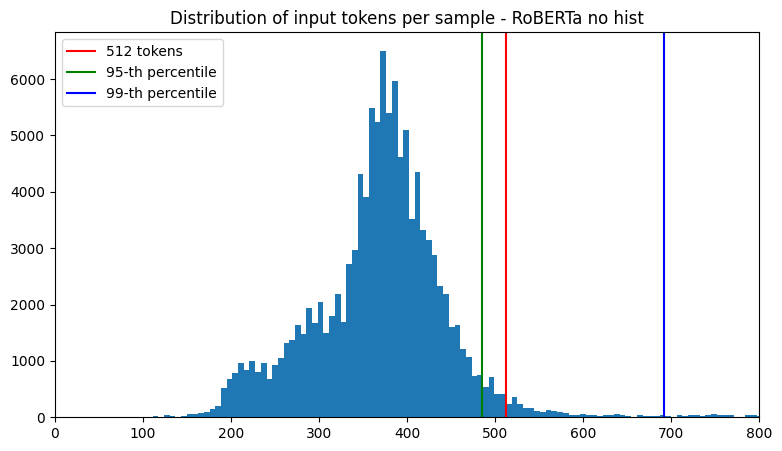

In [ ]:
k = AutoTokenizer.from_pretrained("distilroberta-base")

input = train_data['question'] + k.sep_token + k.sep_token + train_data['passage']
num_tokens_no_hist = input.apply(lambda text: len(k(text).input_ids))

# input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(num_tokens_no_hist, bins=200)
plt.axvline(512, c='r', label='512 tokens')
plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
plt.legend()
plt.xlim(0, 800)
plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# plt.subplot(1, 2, 2)
# plt.hist(num_tokens_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa with hist')
plt.show()

Choosing 512 as max length, more than 95% of the input can be represented.

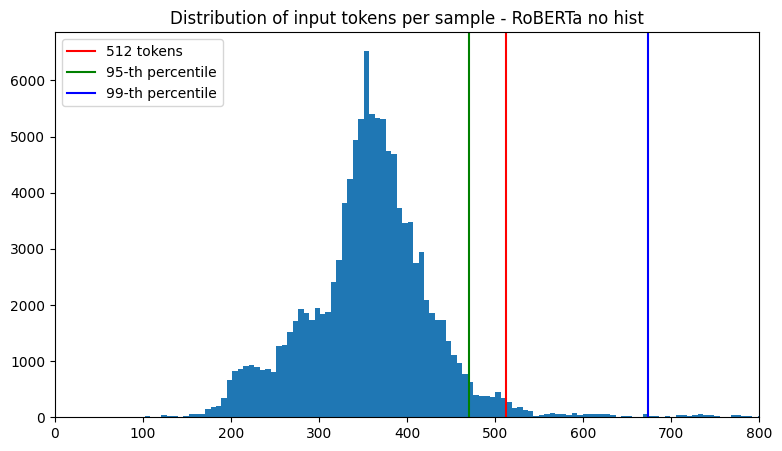

In [ ]:
k = AutoTokenizer.from_pretrained(BERT_TINY)

input = train_data['question'] + k.sep_token + k.sep_token + train_data['passage']
num_tokens_no_hist = input.apply(lambda text: len(k(text).input_ids))

# input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.hist(num_tokens_no_hist, bins=200)
plt.axvline(512, c='r', label='512 tokens')
plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
plt.legend()
plt.xlim(0, 800)
plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# plt.subplot(1, 2, 2)
# plt.hist(num_tokens_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa with hist')
plt.show()

# [Task 3] Model definition

As first thing try to understand what is the maximum length for the input that we should take

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("distilroberta-base")

# input = train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_no_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

# # input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# # num_tokens_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

# plt.figure(figsize=(20, 5))
# plt.subplot(1, 2, 1)
# plt.hist(num_tokens_no_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - RoBERTa no hist')

# # plt.subplot(1, 2, 2)
# # plt.hist(num_tokens_hist, bins=200)
# # plt.axvline(512, c='r', label='512 tokens')
# # plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# # plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# # plt.legend()
# # plt.xlim(0, 800)
# # plt.title('Distribution of input tokens per sample - RoBERTa with hist')
# plt.show()

In [ ]:
# tokenizer = AutoTokenizer.from_pretrained("prajjwal1/bert-tiny")

# input = train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# num_tokens_no_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

# # input = train_data['history'] + train_data['question'] + tokenizer.sep_token + tokenizer.sep_token + train_data['passage']
# # num_tokens_hist = input.apply(lambda text: len(tokenizer(text).input_ids))

# plt.figure(figsize=(20, 5))
# plt.subplot(1, 2, 1)
# plt.hist(num_tokens_no_hist, bins=200)
# plt.axvline(512, c='r', label='512 tokens')
# plt.axvline(np.percentile(num_tokens_no_hist, 95), c='g', label='95-th percentile')
# plt.axvline(np.percentile(num_tokens_no_hist, 99), c='b', label='99-th percentile')
# plt.legend()
# plt.xlim(0, 800)
# plt.title('Distribution of input tokens per sample - BERT-tiny no hist')

# # plt.subplot(1, 2, 2)
# # plt.hist(num_tokens_hist, bins=200)
# # plt.axvline(512, c='r', label='512 tokens')
# # plt.axvline(np.percentile(num_tokens_hist, 95), c='g', label='95-th percentile')
# # plt.axvline(np.percentile(num_tokens_hist, 99), c='b', label='99-th percentile')
# # plt.legend()
# # plt.xlim(0, 800)
# # plt.title('Distribution of input tokens per sample - RoBERTa with hist')
# plt.show()

In [ ]:
DISTIL_ROBERTA = "distilroberta-base" # T=512
BERT_TINY = "prajjwal1/bert-tiny"

class QAEncoderDecoderModel(EncoderDecoderModel):
    def __init__(
        self,
        encoder: transformers.PreTrainedModel,
        decoder: transformers.PreTrainedModel,
        config: Optional[transformers.PretrainedConfig] = None,
    ):
        super(QAEncoderDecoderModel, self).__init__(encoder=encoder,
                                                    decoder=decoder,
                                                    config=config)

    def tie_weights(self):
        # tie encoder & decoder if needed
        if self.config.tie_encoder_decoder:
            # tie encoder and decoder base model
            encoder_base_model_prefix = self.encoder.base_model_prefix
            decoder_base_model_prefix = self.decoder.base_model_prefix
            self._tie_encoder_decoder_weights(
                self.encoder._modules[encoder_base_model_prefix],
                self.decoder._modules[decoder_base_model_prefix],
                self.decoder.base_model_prefix)
    
    # just a wrapper to pass passage_mask and token_type_ids
    def forward(self, input_ids: Optional[torch.LongTensor] = None,
                attention_mask: Optional[torch.FloatTensor] = None,
                passage_mask: Optional[torch.LongTensor] = None,
                token_type_ids: Optional[torch.LongTensor] = None,
                decoder_input_ids: Optional[torch.LongTensor] = None,
                decoder_attention_mask: Optional[torch.BoolTensor] = None,
                encoder_outputs: Optional[Tuple[torch.FloatTensor]] = None,
                past_key_values: Tuple[Tuple[torch.FloatTensor]] = None,
                inputs_embeds: Optional[torch.FloatTensor] = None,
                decoder_inputs_embeds: Optional[torch.FloatTensor] = None,
                labels: Optional[torch.LongTensor] = None,
                use_cache: Optional[bool] = None,
                output_attentions: Optional[bool] = None,
                output_hidden_states: Optional[bool] = None,
                return_dict: Optional[bool] = None, **kwargs) -> Union[Tuple, transformers.modeling_outputs.Seq2SeqLMOutput]:
        
        return super().forward(input_ids, attention_mask, decoder_input_ids, decoder_attention_mask, encoder_outputs,
                               past_key_values, inputs_embeds, decoder_inputs_embeds, labels, use_cache, output_attentions,
                               output_hidden_states, return_dict, passage_mask=passage_mask, token_type_ids=token_type_ids, **kwargs)

class RationaleEncoder(transformers.PreTrainedModel):
    base_model_prefix = "encoder"

    # supports_gradient_checkpointing = True

    def __init__(self, encoder, config) -> None:
        # self.config_class = self.encoder.config_class
        # self._init_weights = self.encoder._init_weights
        # self._set_gradient_checkpointing = self.encoder._set_gradient_checkpointing
        # self._keys_to_ignore_on_load_missing = self.encoder._keys_to_ignore_on_load_missing

        super().__init__(config)
        self.config = config

        self.encoder = encoder
        classifier_dropout = (config.classifier_dropout
                              if config.classifier_dropout is not None else
                              config.hidden_dropout_prob)
        self.rationale_dropout = nn.Dropout(classifier_dropout)
        self.rationale_head = TokenSelectionHead(config)

        # self.ynr_dropout = nn.Dropout(classifier_dropout)
        # self.proj_ynr = nn.Linear(config.hidden_size, 3, bias=True)

        # Initialize weights and apply final processing
        # self.post_init()

    def forward(self,
                input_ids: Optional[torch.Tensor] = None,
                attention_mask: Optional[torch.Tensor] = None,
                inputs_embeds: Optional[torch.FloatTensor] = None,
                passage_mask: Optional[torch.Tensor] = None,
                output_attentions: Optional[bool] = None,
                output_hidden_states: Optional[bool] = None,
                return_dict: Optional[bool] = None,
                **kwargs) -> Tuple[torch.Tensor]:
        assert passage_mask is not None, "Passage mask is not present"

        outputs = self.encoder(input_ids=input_ids,
                               attention_mask=attention_mask,
                               inputs_embeds=inputs_embeds,
                               output_attentions=output_attentions,
                               output_hidden_states=output_hidden_states,
                               return_dict=return_dict,
                               **kwargs)

        last_hidden_state = outputs[0]
        pooled_output = outputs[1]

        sequence_output = self.rationale_dropout(last_hidden_state)
        p_token = self.rationale_head(sequence_output)
        p_token = p_token.masked_fill(~passage_mask.unsqueeze(-1).bool(), 1)
        last_hidden_state = last_hidden_state * p_token

        # loss = None
        # if labels is not None:
        #     loss_fct = CrossEntropyLoss()
        #     loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

        # TODO: remove pooled_output if yes_no_head is not used
        if not return_dict:
            return (last_hidden_state, pooled_output) + outputs[2:]

        return transformers.modeling_outputs.BaseModelOutputWithPooling(
            last_hidden_state=last_hidden_state,
            pooler_output=pooled_output,
            hidden_states=outputs.hidden_states,
            attentions=outputs.attentions,
        )


class TokenSelectionHead(nn.Module):

    def __init__(self, config) -> None:
        super().__init__()
        self.dense = nn.Linear(config.hidden_size,
                               config.hidden_size,
                               bias=True)
        if isinstance(config.hidden_act, str):
            self.act_fn = transformers.modeling_utils.get_activation(
                config.hidden_act)
        else:
            self.act_fn = config.hidden_act
        self.hidden_to_logit = nn.Linear(config.hidden_size, 1, bias=True)
        self.sigmoid = nn.Sigmoid()

    def forward(self, hidden_states: torch.Tensor) -> torch.Tensor:
        hidden_states = self.dense(hidden_states)
        hidden_states = self.act_fn(hidden_states)
        logits = self.hidden_to_logit(hidden_states)
        p_token = self.sigmoid(logits)
        return p_token


def make_bert_encoder_decoder_model(checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoder = AutoModel.from_pretrained(checkpoint)
    encoder = RationaleEncoder(encoder, encoder.config)
    decoder = transformers.AutoModelForCausalLM.from_pretrained(
        checkpoint,
        is_decoder=True,
        add_cross_attention=True,
        decoder_start_token_id=tokenizer.cls_token_id)

    config = transformers.EncoderDecoderConfig.from_encoder_decoder_configs(
        encoder.config,
        decoder.config,
        tie_encoder_decoder=True,
        pad_token_id=tokenizer.pad_token_id,
        decoder_start_token_id=tokenizer.cls_token_id,
        eos_token_id=tokenizer.sep_token_id,
        vocab_size=decoder.config.vocab_size,
        max_length=64,
        min_length=2,
        finetuning_task=False
        #no_repeat_ngram_size=3,
        #repetition_penalty=3.0,
        #num_beams=10
    )

    model = QAEncoderDecoderModel(encoder=encoder,
                                  decoder=decoder,
                                  config=config)

    return tokenizer, model

class TokenizedDataset(Dataset):

    def __init__(self, df, tokenizer, encoder_max_len=512, decoder_max_len=64):
        super(TokenizedDataset).__init__()
        self.df = df
        self.tokenizer = tokenizer
        #self.history = history
        self.encoder_max_len = encoder_max_len
        self.decoder_max_len = decoder_max_len

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        passage = row.passage
        # history = row.history
        question = row.question
        answer = row.answer

        # INPUT:  [CLS] QUESTION [SEP] PASSAGE [SEP] [PAD]*
        input_encoding = self.tokenizer(
            question,
            passage,
            padding='max_length',
            truncation=True,
            max_length=self.encoder_max_len,
        )

        # OUTPUT: [CLS] ANSWER [SEP] [PAD]*
        output_encoding = self.tokenizer(answer,
                                         truncation=True,
                                         padding='max_length',
                                         max_length=self.decoder_max_len)

        labels = output_encoding.input_ids

        # Ignore the loss of the [PAD] labels by setting them to -100
        labels = [
            -100 if token == self.tokenizer.pad_token_id else token
            for token in labels
        ]
        labels = torch.tensor(labels, dtype=torch.int64)

        inputs = {
            'input_ids':
            torch.tensor(input_encoding.input_ids, dtype=torch.int64),
            'attention_mask':
            torch.tensor(input_encoding.attention_mask, dtype=torch.int64),
            'token_type_ids':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            'passage_mask':
            torch.tensor(input_encoding.token_type_ids, dtype=torch.int64),
            # #rationale
            # 'rat_start_idx':
            # torch.tensor(start_idx, dtype=torch.int64),
            # 'rat_end_idx':
            # torch.tensor(end_idx, dtype=torch.int64)
        }

        return inputs, labels

# [Task 4] Question generation with text passage $P$ and question $Q$

We want to define $f_\theta(P, Q)$: consider a dialogue on text passage $P$. For each question $Q_i$ at dialogue turn $i$, we want $f_\theta(P, Q_i) \approx A_i$.

- Our question-answering model requires two inputs: the passage $P$ and the question $Q_i$.
- The model generates the answer $A_i$.


To facilitate easy access to these inputs and outputs, we need to organize our dataset accordingly.

In [ ]:
def train_model(model,
                train_dataset,
                val_dataset,
                epochs=3):
    
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print("Creating datasets...")

    # Prepare DataLoaders
    print("Creating dataloaders...")
    train_loader = create_reproducible_dataloader(train_dataset,
                              batch_size=4,
                              drop_last=False,
                              shuffle=True,
                              num_workers=2,
                              pin_memory=True
                              )
    val_loader = create_reproducible_dataloader(val_dataset,
                            batch_size=4,
                            drop_last=False,
                            shuffle=True,
                            num_workers=2,
                            pin_memory=True
                            )

    optimizer = AdamW(model.parameters(), lr=5e-5)

    train_loss, val_loss = [], []
    tot_steps = 0
    model.to(device)

    print("Training...")
    pre_epoch_val_loss = 10000
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0.0
        optimizer.zero_grad()

        # train step
        for idx, (inputs, labels) in enumerate(tqdm(train_loader)):
        #for idx, (inputs, labels) in enumerate(train_loader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = labels.to(device)
            loss = model(**inputs, labels=labels).loss

            epoch_loss += loss.item()
            tot_steps += labels.shape[0]

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        avg_loss = epoch_loss / len(train_loader)
        train_loss.append(avg_loss)

        # validation step
        model.eval()
        epoch_val_loss = 0
        with torch.no_grad():
            for idx, (inputs, labels) in enumerate(tqdm(val_loader)):
                inputs = {k: v.to(device) for k, v in inputs.items()}
                labels = labels.to(device)
                # Forward pass
                loss = model(**inputs, labels=labels).loss

                # Accumulate loss
                epoch_val_loss += float(loss)

        avg_val_loss = epoch_val_loss / len(val_loader)
        val_loss.append(avg_val_loss)

        print(
            f'Epoch = {epoch}: train_loss = {avg_loss:.4f}; val_loss = {avg_val_loss:.4f}'
        )
        
        if epoch_val_loss < pre_epoch_val_loss:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'loss': avg_loss,
                }, f"./checkpoints/bert-tiny_e{epoch}.pt")
            pre_epoch_val_loss = epoch_val_loss

    print("Train complete!")
    return train_loss, val_loss

def eval_model(tokenizer, model, dataset, tokenized_dataset, **kwargs):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    dataloader = DataLoader(tokenized_dataset,
                            batch_size=64,
                            drop_last=False,
                            shuffle=False,
                            num_workers=2,
                            pin_memory=True)

    pred = []
    model.eval()
    with torch.no_grad():
        for inputs, labels in tqdm(dataloader):
            inputs = {k: v.to(device) for k, v in inputs.items()}
            labels = torch.tensor([
                                    [tokenizer.pad_token_id if token == -100 else token for token in label] for label in labels
                                  ], dtype=torch.int64).to(device)

            # Forward pass
            pred_ids = model.generate(input_ids = inputs["input_ids"],
                                      attention_mask = inputs["attention_mask"],
                                      passage_mask = inputs["passage_mask"],
                                      token_type_ids = inputs["token_type_ids"])

            pred.extend(tokenizer.batch_decode(pred_ids, skip_special_tokens=True))

    # F1-score
    f1_scores = list(
        map(lambda p, a: squad_f1.compute_f1(p, a), pred, dataset['answer'])
    )
    
    print(pred)
    return np.mean(f1_scores)

In [ ]:
seeds = [42]

for seed in seeds:
    print(f'Running with seed: {seed}')
    set_seed(seed)
    
    train_data, val_data = restore_dataset("datasets/train_data_10k.pkl", "datasets/val_data_10k.pkl")

    tokenizer, model = make_bert_encoder_decoder_model(BERT_TINY)
    train_dataset = TokenizedDataset(train_data, tokenizer)
    val_dataset = TokenizedDataset(val_data, tokenizer)
    
    train_loss, val_loss = train_model(model, train_dataset, val_dataset)

    print("\n Strarting evaluation on train set: ")
    f1_train = eval_model(tokenizer, model, train_data, train_dataset)

    print("\n Strarting evaluation on validation set: ")
    f1_val = eval_model(tokenizer, model, val_data, val_dataset)

    print(f"Avg F1-score: train = {f1_train:.4f}, val = {f1_val:.4f}\n")

# [Task 5]
- Our question-answering model requires three inputs: the passage $P$, the question $Q_i$ and, possibly, the history $H=\left(Q_1, A_1, ..., Q_{i-1}, A_{i-1}\right)$.
- The model generates the answer $A_i$.

To facilitate easy access to these inputs and outputs, we need to organize our dataset accordingly.

In [ ]:
max_length = 512
tokenizer = AutoTokenizer.from_pretrained(DISTIL_ROBERTA)

def un_cazzo(row):
    fixed_rationale, span_start, span_end = fix_rationale(row["passage"], row["rationale"],
                                                          row["span_start"], row["span_end"])
    return {"rationale": fixed_rationale,
            "span_start": span_start,
            "span_end": span_end}

def preprocess_training_examples(examples):
    questions = [q.strip() for q in examples["question"]]
    inputs = tokenizer(
        questions,
        examples["passage"],
        max_length=max_length,
        truncation="only_second",
        return_offsets_mapping=True,
        padding="max_length",
    )

    offset_mapping = inputs["offset_mapping"]
    start_positions = []
    end_positions = []

    for i, offset in enumerate(offset_mapping):
        
        start_char = examples["span_start"][i]
        end_char = examples["span_end"][i]
        sequence_ids = inputs.sequence_ids(i)

        # Find the start and end of the context
        idx = 0
        while sequence_ids[idx] != 1:
            idx += 1
        passage_start = idx
        while sequence_ids[idx] == 1:
            idx += 1
        passage_end = idx - 1

        passage_mask = np.zeros_like(sequence_ids)
        passage_mask[passage_start:passage_end+1] = 1

        # If the answer is not fully inside the context, label is (0, 0)
        if offset[passage_start][0] > start_char or offset[passage_end][1] < end_char:
            start_positions.append(0)
            end_positions.append(0)
        else:
            # Otherwise it's the start and end token positions
            idx = passage_start
            while idx <= passage_end and offset[idx][0] <= start_char:
                idx += 1
            start_positions.append(idx-1)

            idx = passage_end
            while idx >= passage_start and offset[idx][1] >= end_char:
                idx -= 1
            end_positions.append(idx + 1)

    inputs["start_positions"] = start_positions
    inputs["end_positions"] = end_positions
    #inputs["passage_mask"] = passage_mask
    
    return inputs

In [ ]:
#train_data, val_data =  pd.read_pickle("datasets/train_data_10k.pkl"), pd.read_pickle("datasets/val_data_10k.pkl")

train_dataset = datasets.Dataset.from_pandas(train_data.reset_index(drop=True))
val_dataset = datasets.Dataset.from_pandas(val_data.reset_index(drop=True))

dataset = datasets.DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

print(dataset)

train_dataset = dataset["train"].map(
    un_cazzo
)

train_dataset = train_dataset.map(
    preprocess_training_examples,
    batched=True
    #remove_columns=dataset["train"].column_names,
)

In [ ]:
idx = 25467

t = train_dataset[idx]
p = train_data.iloc[idx]
print("rat:", t["rationale"])
print("true: ", t["passage"][t["span_start"]:t["span_end"]])
print("pred:", tokenizer.decode(t["input_ids"][t['start_positions']:t['end_positions']+1]))
print(p["span_start"], p["span_end"])
print(t['start_positions'], t['end_positions'])
print(t["offset_mapping"])



In [ ]:
#train_data.reset_index(drop=True, inplace=True)

train_data[train_data["rationale"] == "Lily was ready to take any part of the business of the household and schoolroom"]

In [ ]:
tokenizer._tokenizer.pre_tokenizer.pre_tokenize_str("ciao sono matteo")

In [ ]:
def make_rationale_encoder(checkpoint):
    tokenizer = AutoTokenizer.from_pretrained(checkpoint)
    encoder = AutoModel.from_pretrained(checkpoint)
    encoder = RationaleEncoder(encoder, encoder.config)

    return tokenizer, encoder

In [ ]:
tok, enc = make_rationale_encoder(BERT_TINY)

#train_data, val_data =  pd.read_pickle("datasets/train_data_10k.pkl"), pd.read_pickle("datasets/val_data_10k.pkl")

train_dataset = datasets.Dataset.from_pandas(train_data.reset_index(drop=True))
val_dataset = datasets.Dataset.from_pandas(val_data.reset_index(drop=True))

dataset = datasets.DatasetDict({
    "train": train_dataset,
    "validation": val_dataset
})

train_dataset = dataset["train"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset["train"].column_names,
)

val_dataset = dataset["validation"].map(
    preprocess_training_examples,
    batched=True,
    remove_columns=dataset["validation"].column_names,
)

train_dataset.set_format("pt")
val_dataset.set_format("pt")

In [ ]:
train_loss, val_loss = train_model(enc, train_dataset, val_dataset)

In [ ]:
torch.cuda.empty_cache()